In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import datetime
import pickle
import os

import warnings
warnings.filterwarnings("ignore")

# Data Funnel Plot

In [2]:
ukb = pd.read_csv('processed/ukb_2023-03-14.csv', index_col=0)

ukb_pft = ukb.dropna(subset=['FEV1','FVC'])
ukb_pft['FEV1/FVC'] = ukb_pft['FEV1']/ukb_pft['FVC']
                     # Baseline 
ukb_clean = ukb_pft[['RIDRETH', 'RIDAGEYR', "RIAGENDR",
                     # Anthropometric
                     'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST', 
                     'BMXHIP', 'BMXSIT', 'BMXWT10', 'BMXHT10', 
                     # Gen
                     'GenPC_1', 'GenPC_2',
                     'GenPC_3', 'GenPC_4', 'GenPC_5', 'GenPC_6', 'GenPC_7', 'GenPC_8',
                     'GenPC_9', 'GenPC_10', 'GenPC_11', 'GenPC_12', 'GenPC_13', 'GenPC_14',
                     'GenPC_15', 'GenPC_16', 'GenPC_17', 'GenPC_18', 'GenPC_19', 'GenPC_20',
                     'GenPC_21', 'GenPC_22', 'GenPC_23', 'GenPC_24', 'GenPC_25', 'GenPC_26',
                     'GenPC_27', 'GenPC_28', 'GenPC_29', 'GenPC_30', 'GenPC_31', 'GenPC_32',
                     'GenPC_33', 'GenPC_34', 'GenPC_35', 'GenPC_36', 'GenPC_37', 'GenPC_38',
                     'GenPC_39', 'GenPC_40', 
                     # Smoking
                     "EXCL_SMOKED_100", "EXCL_SMOKER", 
                     # Exposures
                     'DMD_YEARS_IN_UK', 'DMD_Mom_Smoked', 'DMD_Born_UK', 'DMD_Finish_HS',
                     'DMD_Home_Smoke', 'DMD_Veteran', 'DMD_PM10', 'DMD_PM2.5',
                     'DMD_PM2.5_10', 'DMD_Work_Fumes', 'DMD_Work_Exhaust',
                     'DMD_Work_Smoking_Exp', 'DMD_Work_Breathing_Probs', 'DMD_INC',
                     # Respiratory Disease/Symptoms 
                     "MCQ_LUNG_CANCER", "MCQ_RESPIRATORY_DISEASE", 
                     "SYMP_COUGH", "SYMP_PHLEGM", "SYMP_WHEEZING",
                     # PFT 
                     "FEV1","FVC", "FEV1/FVC"]].dropna()

# Healthy cohort 
unhealthy = ["EXCL_SMOKED_100", "EXCL_SMOKER", 
                       "MCQ_LUNG_CANCER", "MCQ_RESPIRATORY_DISEASE", 
                       "SYMP_COUGH", "SYMP_PHLEGM", "SYMP_WHEEZING"]

rows_to_drop = ukb_clean[unhealthy].any(axis=1)
ukb_healthy = ukb_clean[~rows_to_drop]

In [3]:
len(ukb_healthy)

156728

In [4]:
print('Cough most days:', ukb_clean["SYMP_COUGH"].sum())
print('Phlegm most days:', ukb_clean["SYMP_PHLEGM"].sum())
print('Wheezing most days:', ukb_clean["SYMP_WHEEZING"].sum())
print('Lung Cancer:', ukb_clean["MCQ_LUNG_CANCER"].sum())
print('Respiratory Disease:', ukb_clean["MCQ_RESPIRATORY_DISEASE"].sum())

Cough most days: 8852
Phlegm most days: 5503
Wheezing most days: 50740
Lung Cancer: 98
Respiratory Disease: 24993


In [5]:
# Create example data frames with sizes and categories
df1_size = len(ukb)
df1_categories = dict(ukb.RIDRETH.value_counts())

df2_size = len(ukb_pft)
df2_categories = dict(ukb_pft.RIDRETH.value_counts())

df3_size = len(ukb_clean)
df3_categories = dict(ukb_clean.RIDRETH.value_counts())

df4_size = len(ukb_healthy)
df4_categories = dict(ukb_healthy.RIDRETH.value_counts())

# Create example data frame with stages and sizes
df = pd.DataFrame({
    'stage': [f'UKB ({df1_size})', 
              f'With PFT Values ({df2_size})', 
              f'Removed NA ({df3_size})', 
              f'Healthy ({df4_size})'],
    'size': [df1_size, df2_size, df3_size, df4_size],
    'categories': [df1_categories, df2_categories, df3_categories, df4_categories]
})

# Calculate cumulative sizes
df['cumulative_size'] = df['size'].cumsum()

# Create lists for each category
cat_a = []
cat_b = []
cat_c = []
cat_d = []
cat_e = []

for index, row in df.iterrows():
    cat_a.append(row['categories']['White'])
    cat_b.append(row['categories']['Black'])
    cat_c.append(row['categories']['Asian'])
    cat_d.append(row['categories']['South Asian'])
    cat_e.append(row['categories']['Other'])

# Create funnel plot using plotly
fig = go.Figure()

# Define the colors
colors = ['rgb(122, 183, 214)', 'rgb(1, 105, 180)', 
          'rgb(1, 60, 100)', 'rgb(77, 175, 74)', 
          'rgb(60, 120, 30)', 'rgb(200, 200, 200)']

fig.add_trace(go.Funnel(
    x = cat_a,
    y = df['stage'],
    name = "White",
    marker = {"color": colors[0]}
))

fig.add_trace(go.Funnel(
    x = cat_b,
    y = df['stage'],
    name = "Black",
    marker = {"color": colors[1]}
))

fig.add_trace(go.Funnel(
    x = cat_c,
    y = df['stage'],
    name = "Asian",
    marker = {"color": colors[2]}
))

fig.add_trace(go.Funnel(
    x = cat_d,
    y = df['stage'],
    name = "South Asian",
    marker = {"color": colors[3]}
))


fig.add_trace(go.Funnel(
    x = cat_e,
    y = df['stage'],
    name = "Other",
    marker = {"color": colors[4]}
))

fig.update_layout(
    title = "Data Funnel Plot",
    xaxis_title = "Category Size",
    yaxis_title = "Stage",
    font = dict(size = 15), 
    width=1000, # Set the width to 1000
    height=550
)

fig.show()

# Plot Distributions

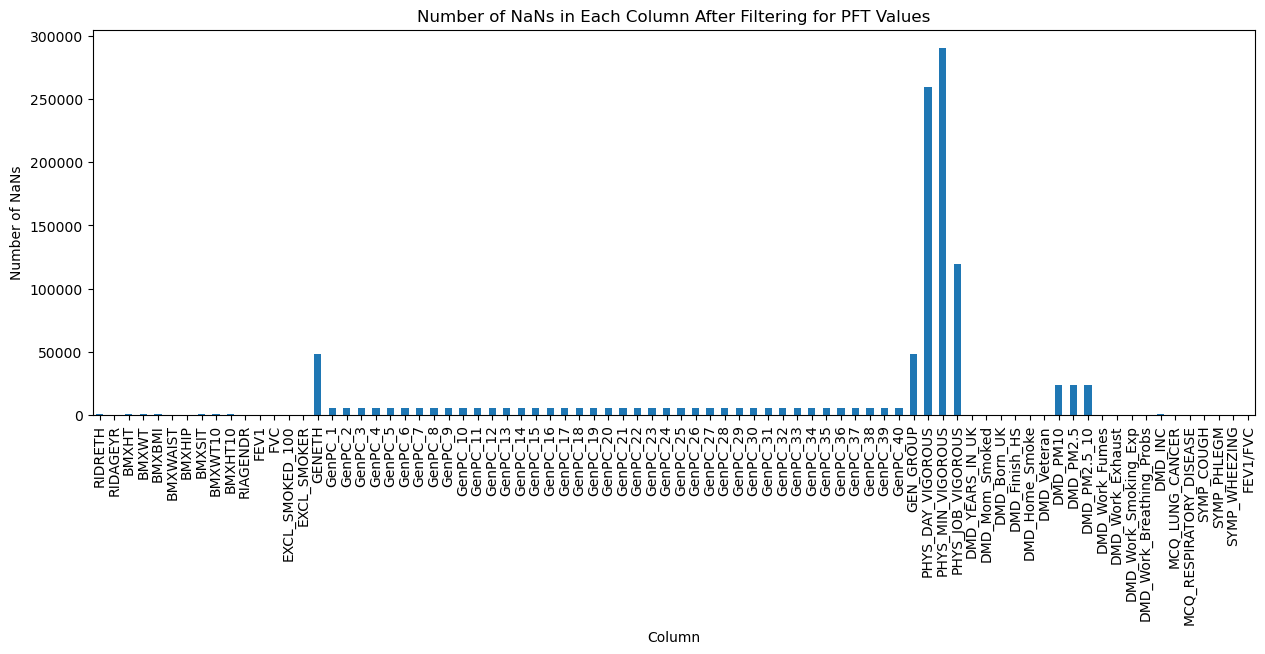

In [6]:
# calculate the number of NaNs in each column
fig, axs = plt.subplots(figsize=(15, 5))

nan_counts = ukb_pft.isna().sum()

# create a bar chart of the NaN counts
nan_counts.plot(kind='bar')
plt.title('Number of NaNs in Each Column After Filtering for PFT Values')
plt.xlabel('Column')
plt.ylabel('Number of NaNs')
plt.show()

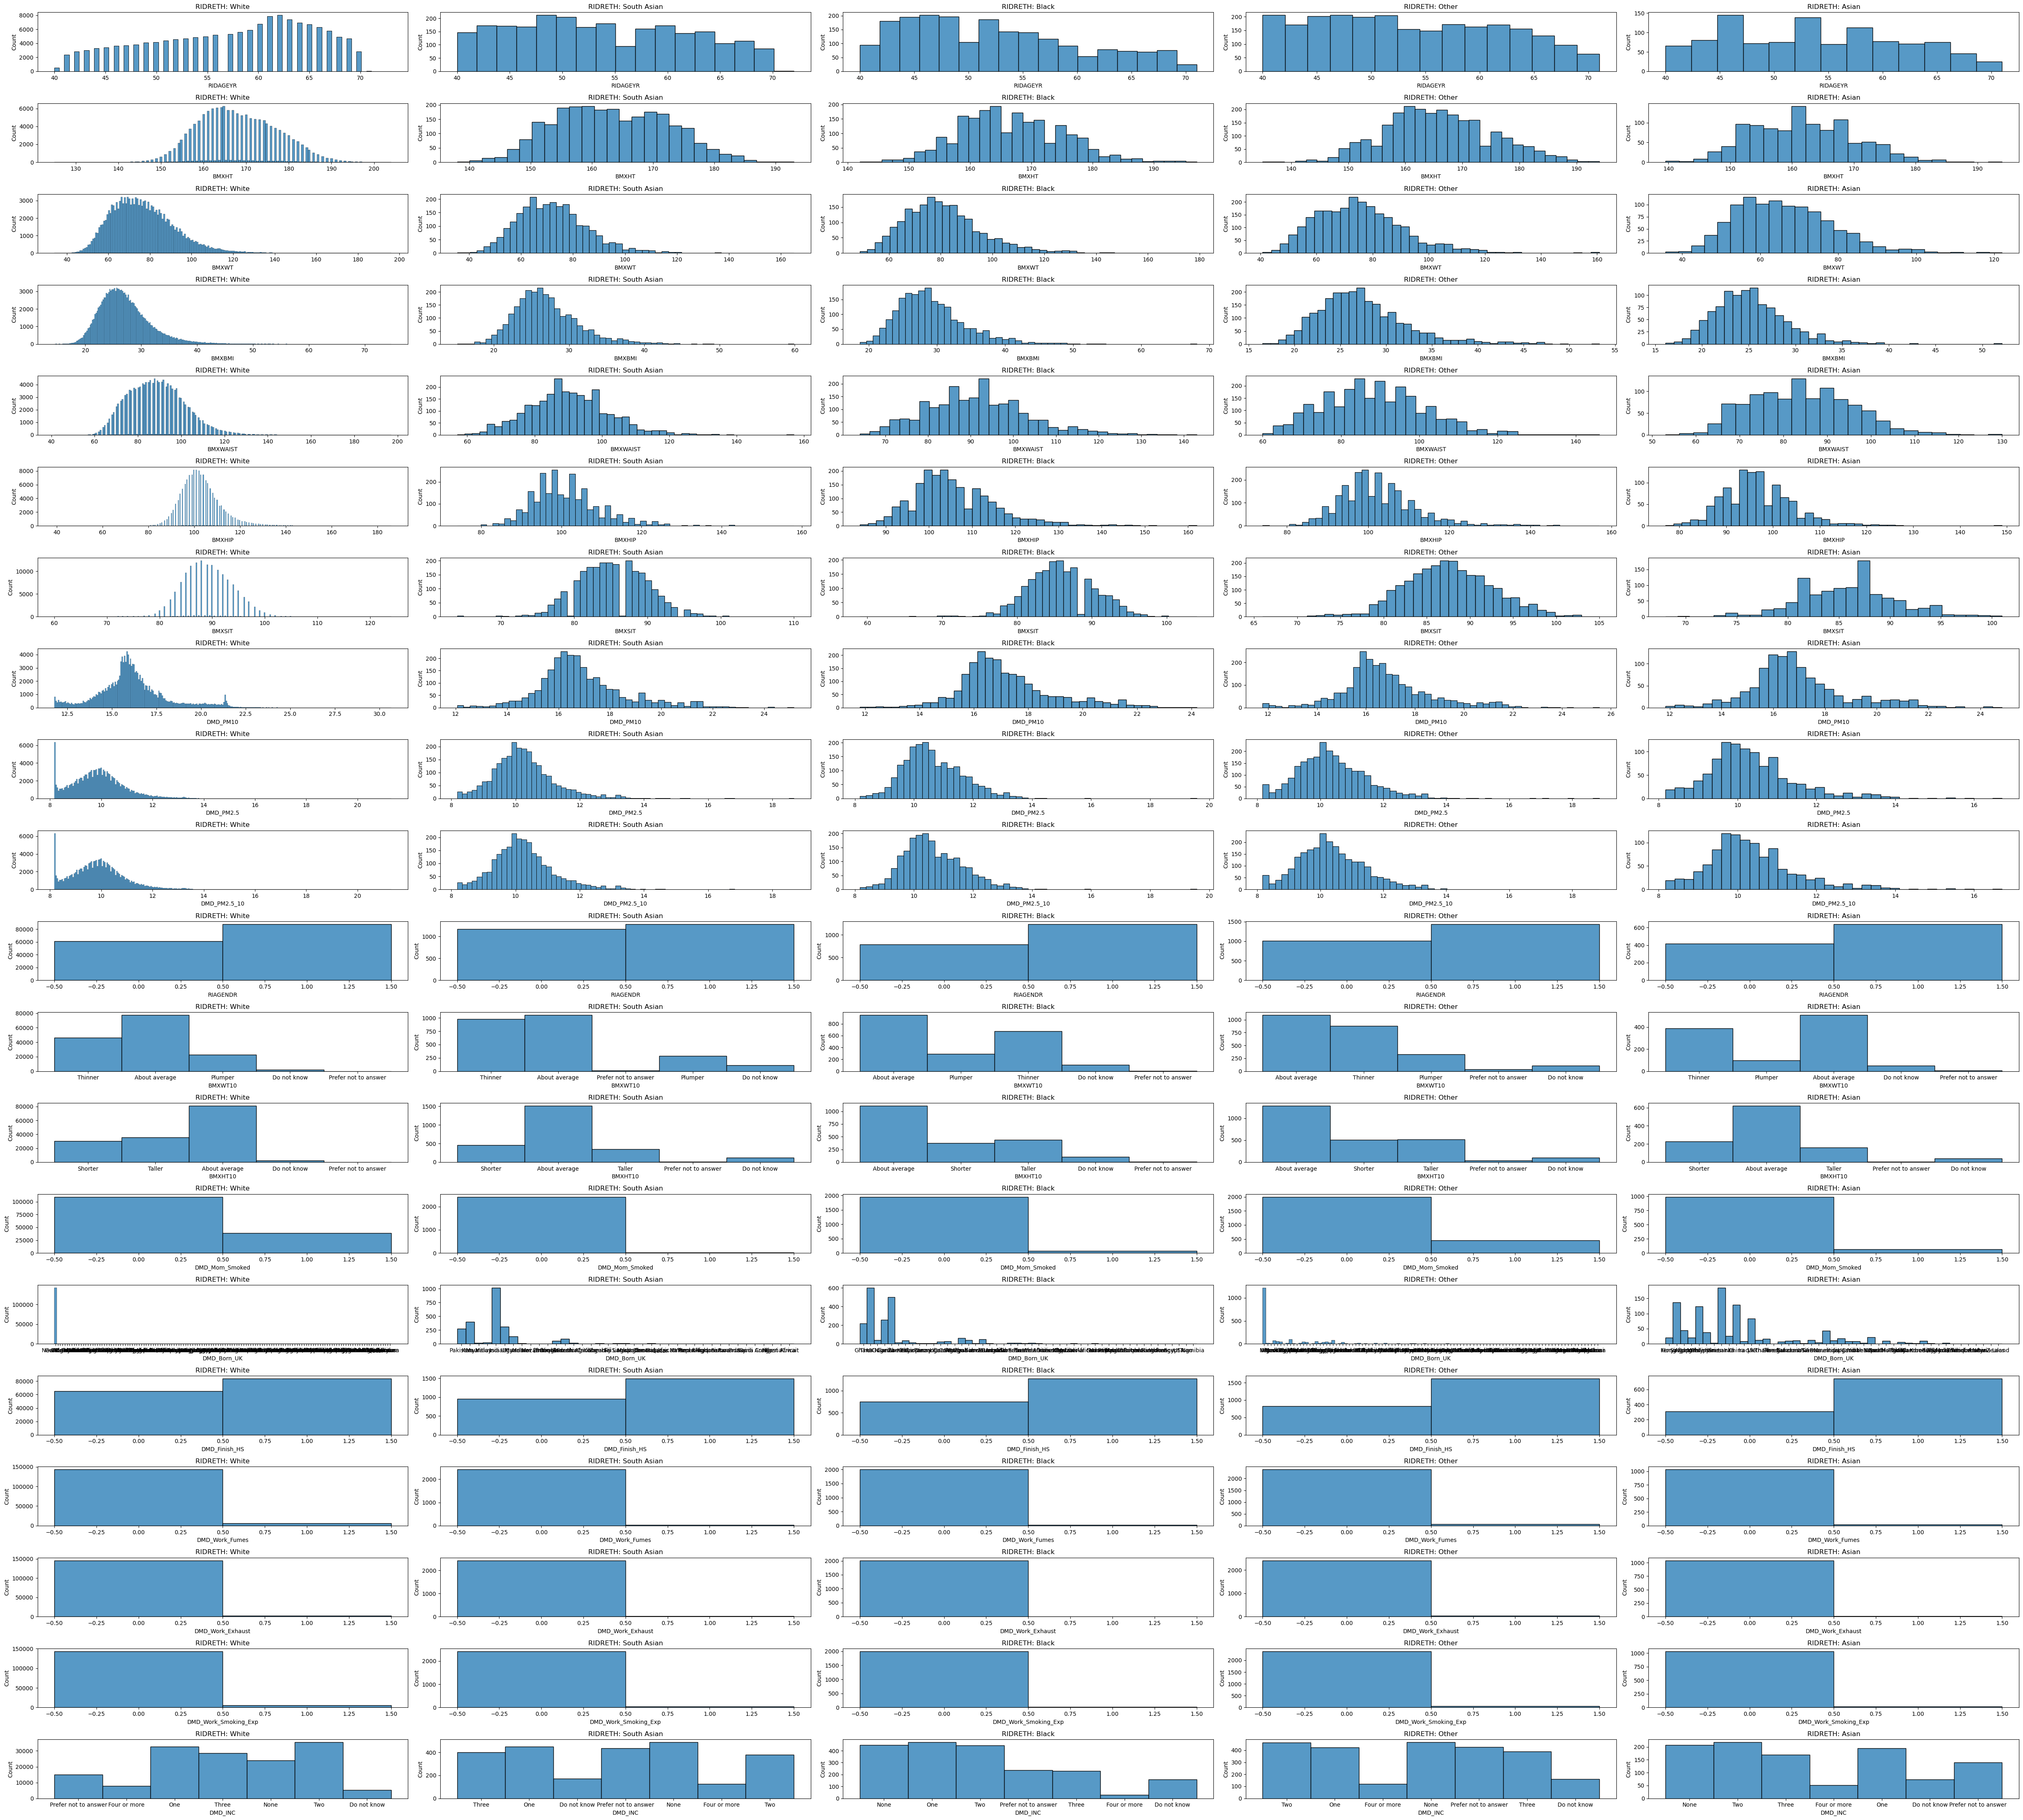

In [7]:
# check which columns are logical
logical_cols = ukb_healthy.select_dtypes(include='bool').columns

# convert logical columns to categorical columns
for col in logical_cols:
    ukb_healthy[col] = ukb_healthy[col].astype('category')
    
columns = ['RIDAGEYR', "RIAGENDR",
         # Anthropometric
         'BMXHT', 'BMXWT', 'BMXBMI', 'BMXWAIST', 
         'BMXHIP', 'BMXSIT', 'BMXWT10', 'BMXHT10', 
         # Exposures
         'DMD_Mom_Smoked', 'DMD_Born_UK', 'DMD_Finish_HS',
         'DMD_PM10', 'DMD_PM2.5',
         'DMD_PM2.5_10', 'DMD_Work_Fumes', 'DMD_Work_Exhaust',
         'DMD_Work_Smoking_Exp', 'DMD_INC',]

category_var = 'RIDRETH'

# Create a figure with subplots for each column
fig, axs = plt.subplots(nrows=len(columns), ncols=len(ukb_healthy[category_var].unique()), figsize=(50, 45))

# Loop over the columns and categories and plot the distribution for each column and category
i = 0 
for col in columns:
    if ukb_healthy[col].dtype in [pd.np.float64, pd.np.int64]:
        for j, category in enumerate(ukb_healthy[category_var].unique()):
            data = ukb_healthy[ukb_healthy[category_var] == category][col]
            if not data.empty:
                sns.histplot(data=data, ax=axs[i,j])
                axs[i,j].set_xlabel(col)
                axs[i,j].set_ylabel('Count')
                axs[i,j].set_title(f'{category_var}: {category}')
        i += 1

for col in columns:
    if ukb_healthy[col].dtype not in [pd.np.float64, pd.np.int64]:
        for j, category in enumerate(ukb_healthy[category_var].unique()):
            data = ukb_healthy[ukb_healthy[category_var] == category][col]
            if not data.empty:
                sns.histplot(data=data, ax=axs[i,j])
                axs[i,j].set_xlabel(col)
                axs[i,j].set_ylabel('Count')
                axs[i,j].set_title(f'{category_var}: {category}')
        i += 1

plt.tight_layout()
plt.show()

# Regression Model

In [8]:
def one_hot_encoding(df, features, target):
    X = df[features]
    y = df[target]
    # Get a list of categorical columns
    categorical_columns = list(X.select_dtypes(include=['object']).columns)

    # Convert categorical columns to one-hot encoded columns
    for column in categorical_columns:
        one_hot = pd.get_dummies(X[column], prefix=column)
        X = X.drop(column, axis=1)
        X = X.join(one_hot)
        
    # Scale features using StandardScaler
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X))
    X_scaled.columns=X.columns
    X_scaled.index=X.index
    return X_scaled, y

def train_test_split_stratified(df, features, target):    
    X_scaled, y = one_hot_encoding(df, features, target)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                        stratify=X_scaled.join(ukb['RIDRETH'])['RIDRETH'],
                                                        test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, X_scaled.columns
    

def bootstrap(X_train, X_test, y_train, y_test, n):
    # Set number of bootstrap samples
    n_bootstraps = n

    # Initialize array to store bootstrap coefficients
    bootstrap_coefs = np.zeros((n_bootstraps, X_train.shape[1]))
    bootstrap_train_mae = np.zeros((n_bootstraps, X_train.shape[0]))
    bootstrap_test_mae = np.zeros((n_bootstraps, X_test.shape[0]))

    # Perform bootstrap resampling and Lasso regression on training data
    for i in range(n_bootstraps):
        # Generate bootstrap sample
        indices = np.random.choice(X_train.index, size=X_train.shape[0], replace=True)
        X_boot = X_train.loc[indices]
        y_boot = y_train[indices]
        # Fit Lasso regression to bootstrap sample
        lasso_boot = Lasso(alpha=0.01)
        lasso_boot.fit(X_boot, y_boot)
        bootstrap_coefs[i, :] = lasso_boot.coef_
        # Predict on train set with bootstrap model
        bootstrap_train_mae[i, :] = mean_absolute_error(y_train, lasso_boot.predict(X_train))
        # Predict on test set with bootstrap model
        bootstrap_test_mae[i, :] = mean_absolute_error(y_test, lasso_boot.predict(X_test))

    # Calculate standard errors and confidence intervals
    z_score = 1.96  # 95% confidence interval
    ci_beta = z_score*np.std(bootstrap_coefs, axis=0, ddof=1)
    ci_train = z_score*np.std(bootstrap_train_mae)
    ci_test = z_score*np.std(bootstrap_test_mae)
    return ci_beta, ci_train, ci_test

def train_regression(df, features, target, penalization=None, mae_by_race=False):
    X_train, X_test, y_train, y_test, features = train_test_split_stratified(df, features, target)

    # Define the hyperparameter grid
    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

    if penalization == 'Ridge':
        # Perform grid search with cross-validation
        model = Ridge()
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train)

        # Train the model with the best hyperparameters
        best_alpha = grid_search.best_params_['alpha']
        model = Ridge(alpha=best_alpha)
        model.fit(X_train, y_train)
        mean_score = -grid_search.best_score_
        
    elif penalization == "Lasso":
        model = Lasso()
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train)

        # Train the model with the best hyperparameters
        best_alpha = grid_search.best_params_['alpha']
        model = Lasso(alpha=best_alpha)
        model.fit(X_train, y_train)
        mean_score = -grid_search.best_score_
        ci_beta, ci_train, ci_test = bootstrap(X_train, X_test, y_train, y_test, 500)
        
    else:
        model = LinearRegression()
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
        mean_score = np.mean(scores)
        best_alpha = 0
        model.fit(X_train, y_train)
        
    # Compute the mean squared error on the test set
    y_pred = model.predict(X_test)
    mse = mean_absolute_error(y_test, y_pred)
    
    if mae_by_race: 
        mae_race = dict(evaluate_by_race(X_test, y_test, target, model))
    else:
        mae_race = None 
    
    model_dict = {}
    model_dict[target] = {
                'Best Hyperparameters': best_alpha,
                'Features': features, 
                'Train MSE': mean_score,
                'Test MSE': mean_absolute_error(y_test, y_pred),
                'Model': model,
                'CI Betas': ci_beta,
                'CI Train': ci_train,
                'CI Test': ci_test,
                'Race MAE': mae_race
                 }
    
    return model_dict

def evaluate_by_race(X, y, target, model):
    # Group the DataFrame by 'group' column
    df = X.join(ukb['RIDRETH'])
    df['Actual'] = y
    df['Predicted'] = model.predict(X)
    grouped_df = df.groupby('RIDRETH')

    # Calculate MAE for each group
    mae = grouped_df.apply(lambda x: mean_absolute_error(x['Actual'], x['Predicted']))
    return mae 
        
def sorted_feature_imp(features, model, ci_coefs):    
    # Sort coefficients
    coef_with_names = list(zip(model.coef_, features, ci_coefs))
    sorted_coef_with_names = sorted(coef_with_names, key=lambda x: abs(x[0]), reverse=True)
    sorted_feature_names = [x[1] for x in sorted_coef_with_names if abs(x[0]) > 0]
    sorted_coefs = [x[0] for x in sorted_coef_with_names if abs(x[0]) > 0]
    sorted_ci_coef =  [x[2] for x in sorted_coef_with_names if abs(x[0]) > 0]
    return sorted_feature_names, sorted_coefs, sorted_ci_coef

def update_model_dict(model, key, m_dict):
    if key in models:
        models[key].update(model_dict) # Append to the existing list
    else:
        models[key] = model_dict.copy()
    return models 

### Train Linear Regression Models 
    1) Without Race
    2) With Race
    3) Stratified by Race 

In [9]:
# Get the current date as a string
today = datetime.date.today().strftime('%Y-%m-%d')

# Define the filename with the current date
filename = 'models_genetic_' + today + '.pkl'

if os.path.exists('models/'+filename):
    # Load the model data from the file
    with open('models/'+filename, 'rb') as f:
        models = pickle.load(f)
else: 
    PFT = ['FEV1', 'FVC', 'FEV1/FVC']
    models = {}

    # Create a figure and three subplots
    for i, pft in enumerate(PFT):
        # Race Free Model for All 
        key = 'Race Free Model'
        cols = list(filter(lambda x: x.startswith(('RIDAGEYR', "RIAGENDR", 'BMX', 'DMD', 'Gen',
                                                  )), ukb_healthy.columns))
        model_dict = train_regression(ukb_healthy, cols, pft, penalization='Lasso', mae_by_race=True)
        models = update_model_dict(models, key, model_dict)

        # Race Included as Feature 
        key = 'Race Included Model'
        cols = list(filter(lambda x: x.startswith(('RID', "RIAGENDR", 'BMX', 'DMD', 'Gen',
                                                    )), ukb_healthy.columns))
        model_dict = train_regression(ukb_healthy, cols, pft, penalization='Lasso', mae_by_race=True)
        models = update_model_dict(models, key, model_dict)

        #Race Stratified Models 
        for race in ukb_healthy['RIDRETH'].unique():
            ukb_healthy_race = ukb_healthy[ukb_healthy['RIDRETH']==race]
            model_dict = train_regression(ukb_healthy_race, cols, pft, penalization='Lasso')
            models = update_model_dict(models, race, model_dict)
    
    # Save the model to a file using pickle and the current date in the filename
    with open(filename, 'wb') as f:
        pickle.dump(models, f)

## Evaluate Models

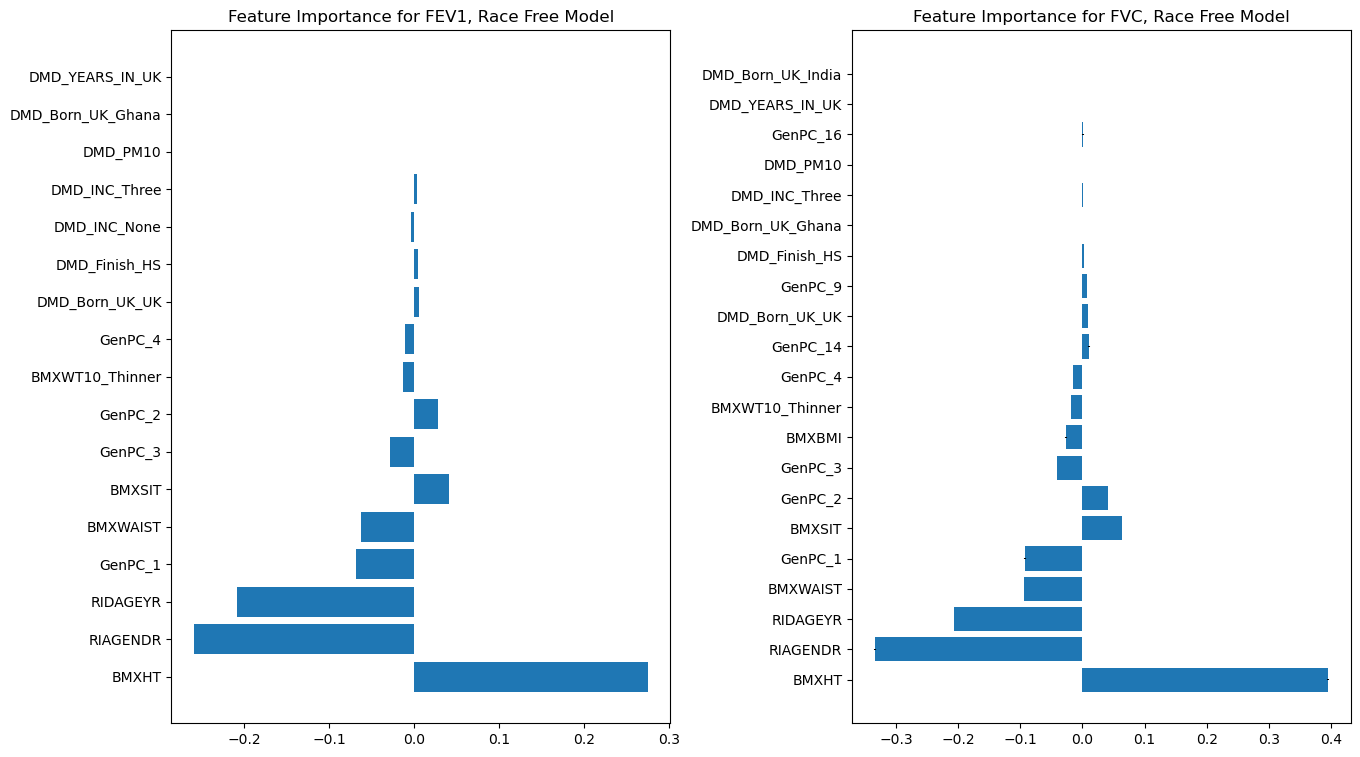

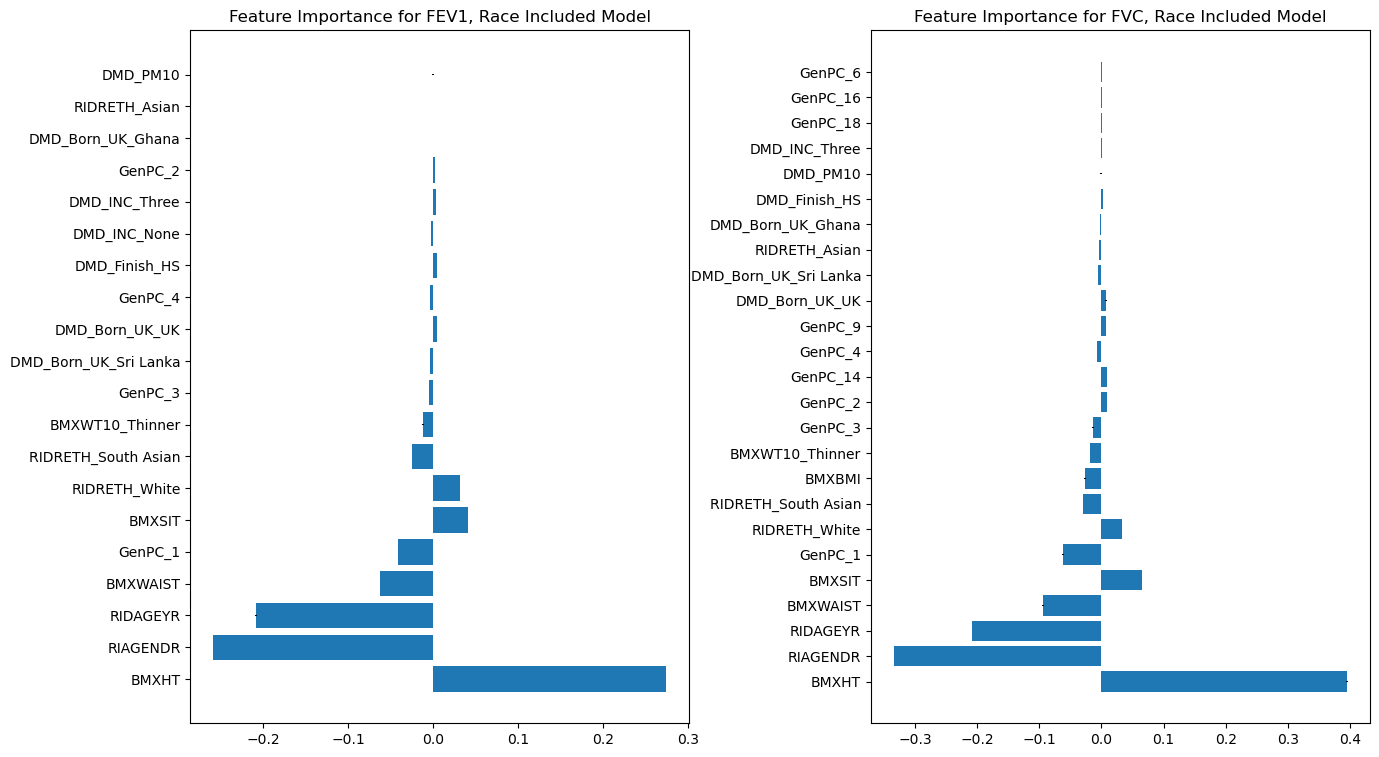

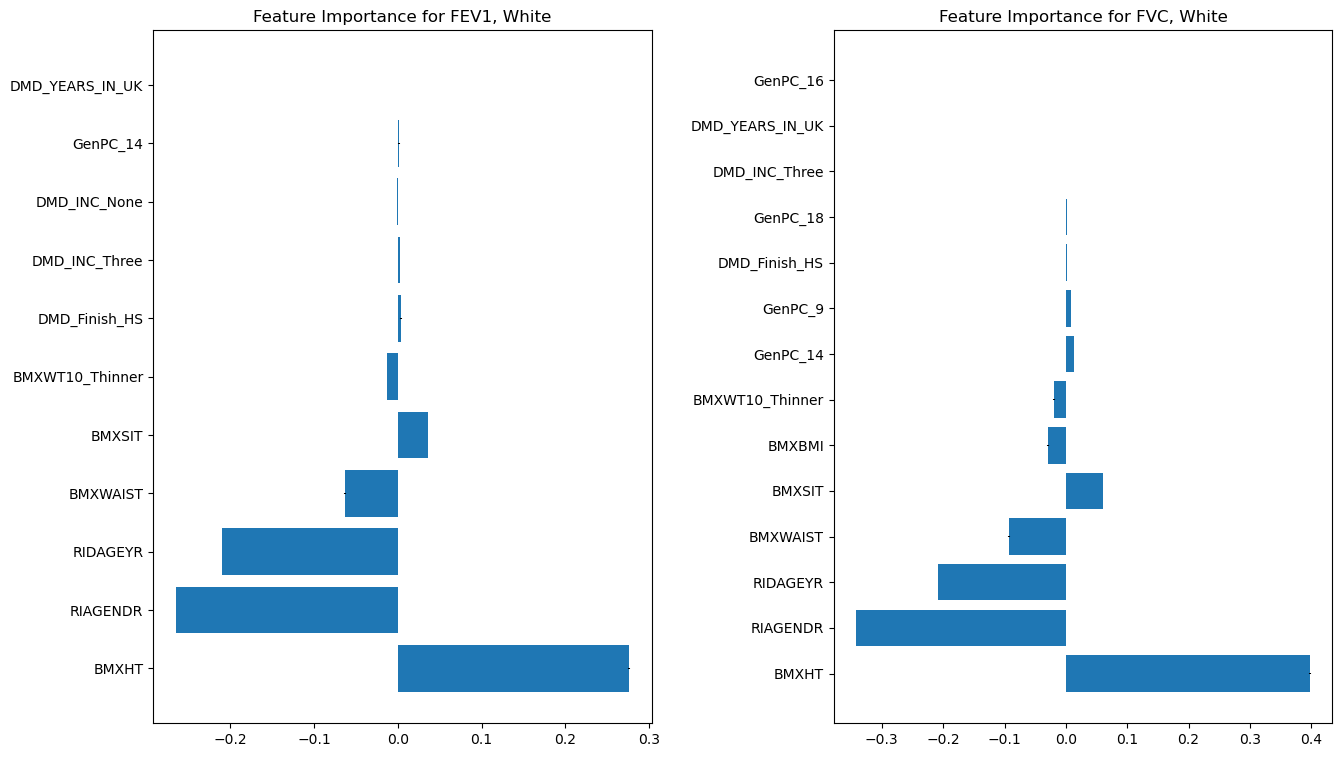

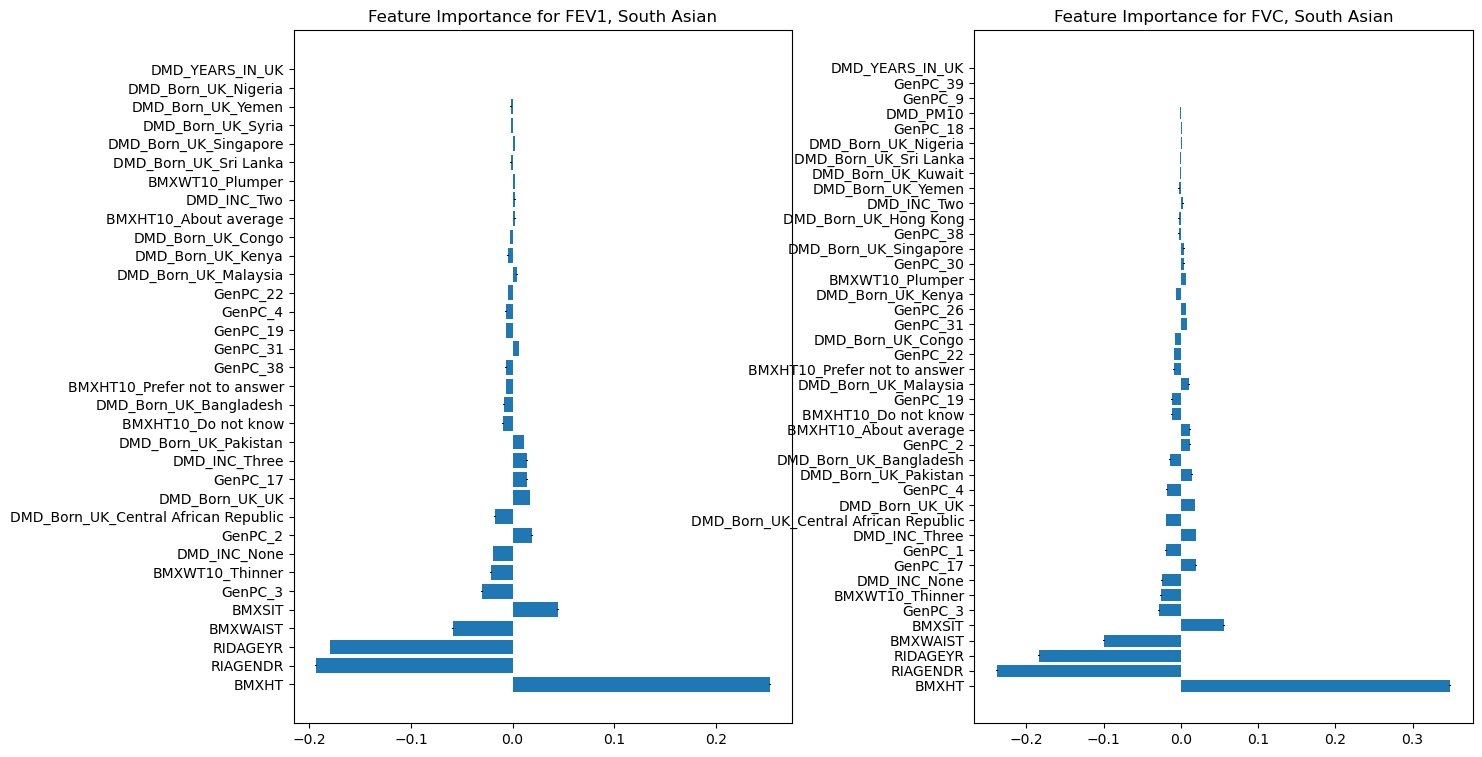

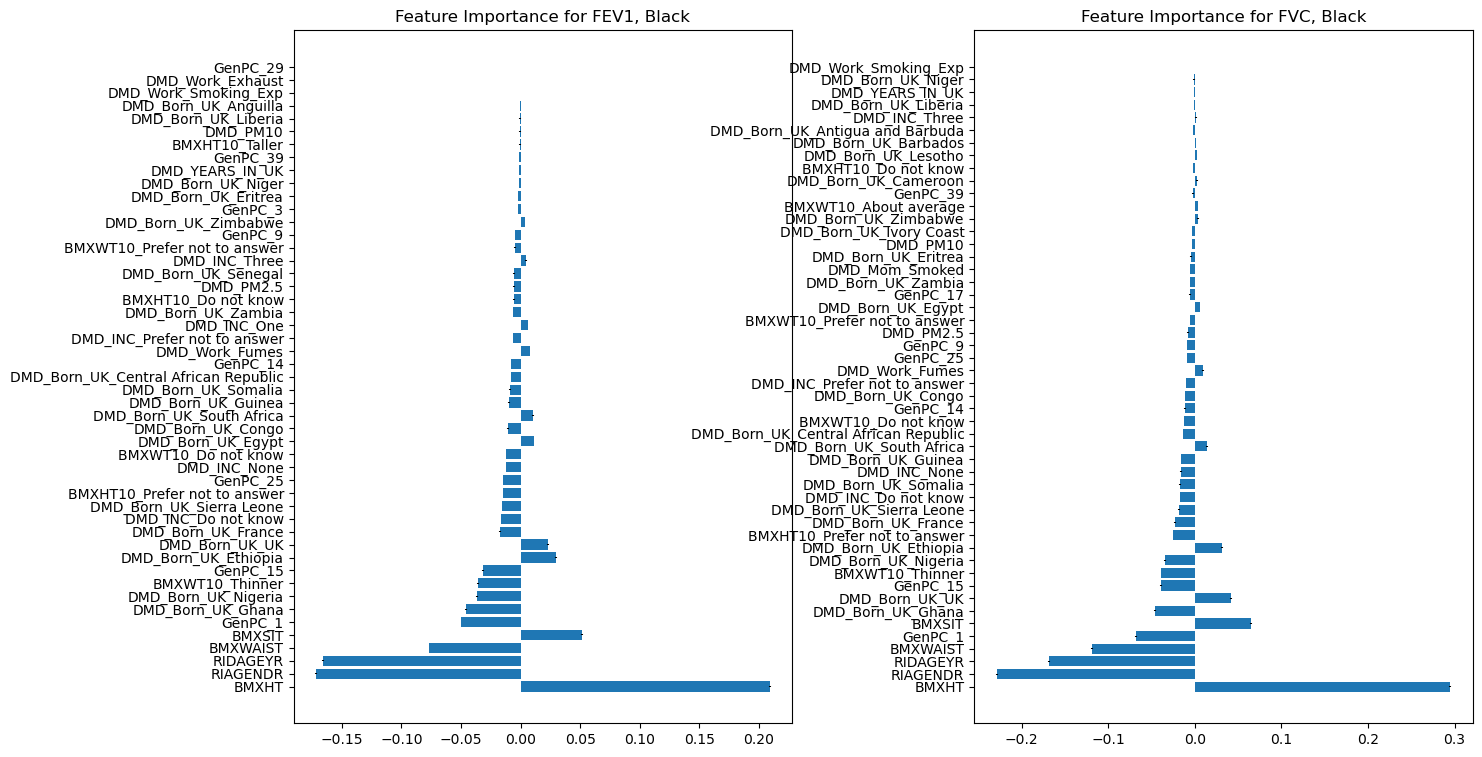

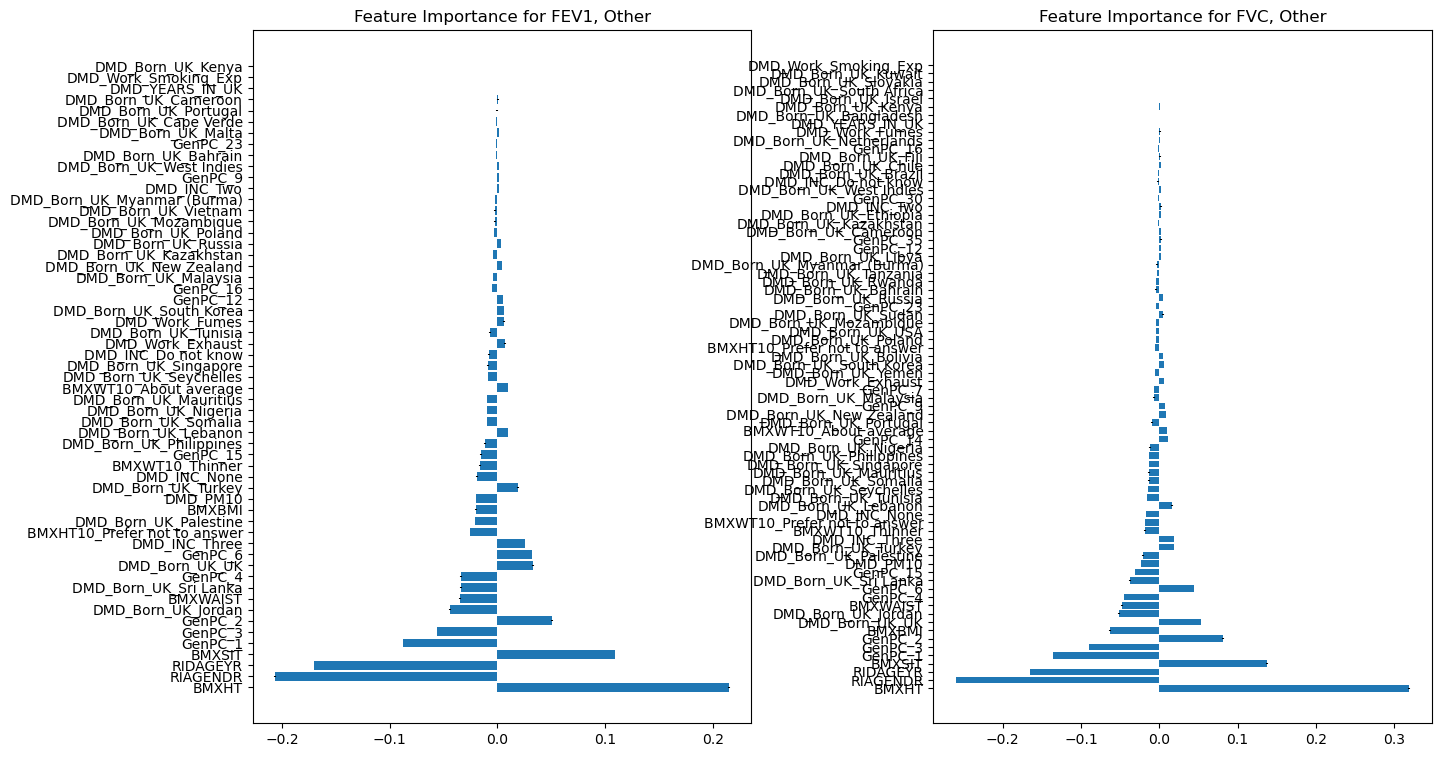

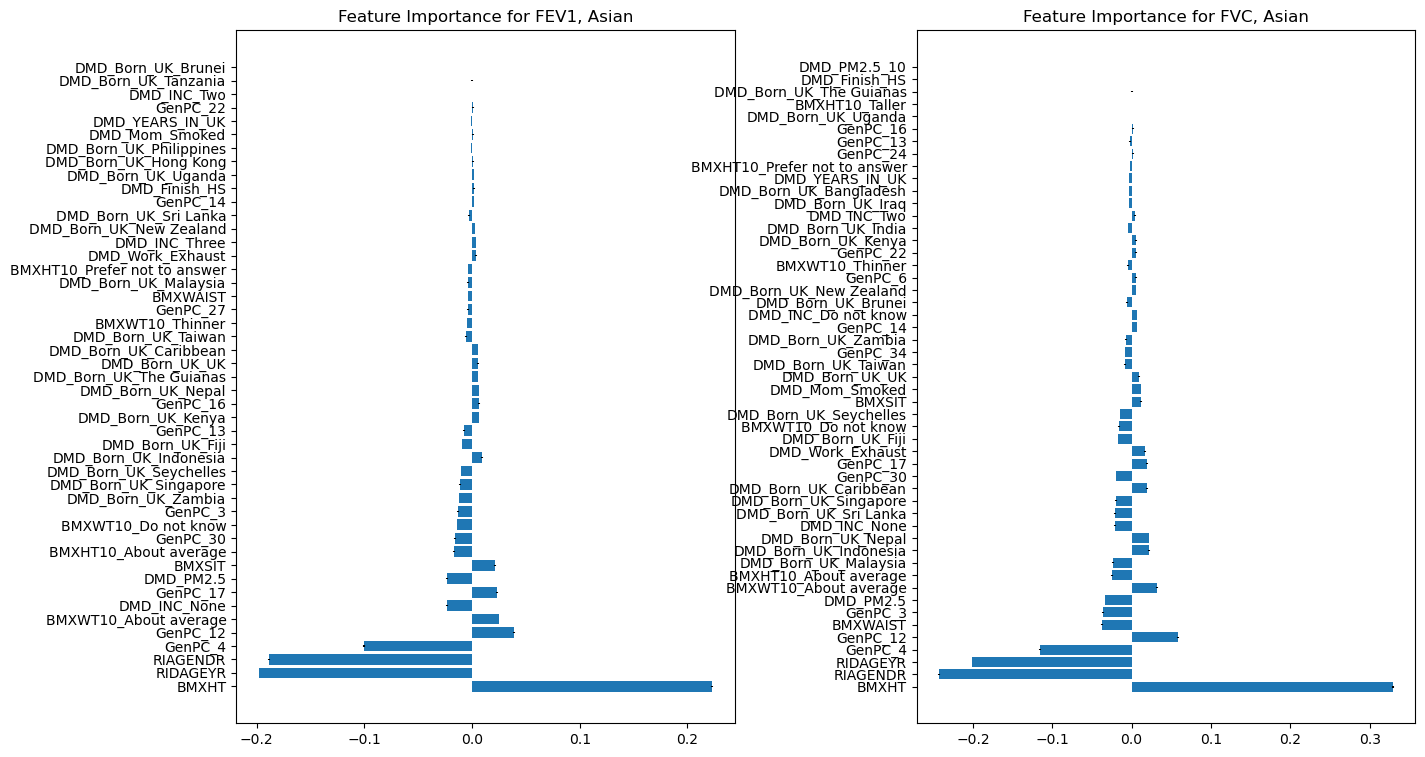

In [13]:
PFT = ['FEV1', 'FVC', 'FEV1/FVC']

# Initialize table
cols = ["Target", "Model", "Alpha", "Train MAE", "Train CI", "Test MAE", "Test CI"]
rows = []

for j, m in enumerate(models.keys()):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    fig.tight_layout(pad=10)
    for i, p in enumerate(PFT):
        model_i = models[m][p]['Model']
        features_i = models[m][p]['Features']
        ci_coef_i = models[m][p]['CI Betas']
        names_sorted, coef_sorted, coef_ci = sorted_feature_imp(features_i, model_i, ci_coef_i)
        row = [p,
           m,
           models[m][p]['Best Hyperparameters'],
           round(models[m][p]['Train MSE'], 3),
           round(models[m][p]['CI Train'], 5),
           round(models[m][p]['Test MSE'], 3),
           round(models[m][p]['CI Test'], 5)]
        rows.append(row)
        if i == 2:
            continue
            
        axes[i].tick_params(axis='y', labelsize=10)
        axes[i].barh(names_sorted, coef_sorted, yerr=coef_ci)
        axes[i].set_title(f"Feature Importance for {p}, {m}")
    plt.show()
    
model_metrics_df = pd.DataFrame(rows, columns=cols)

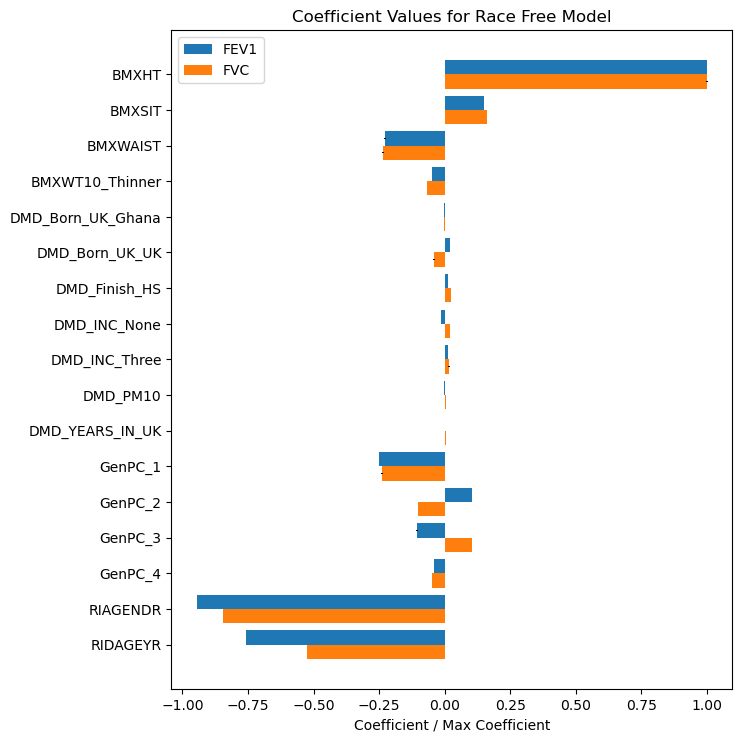

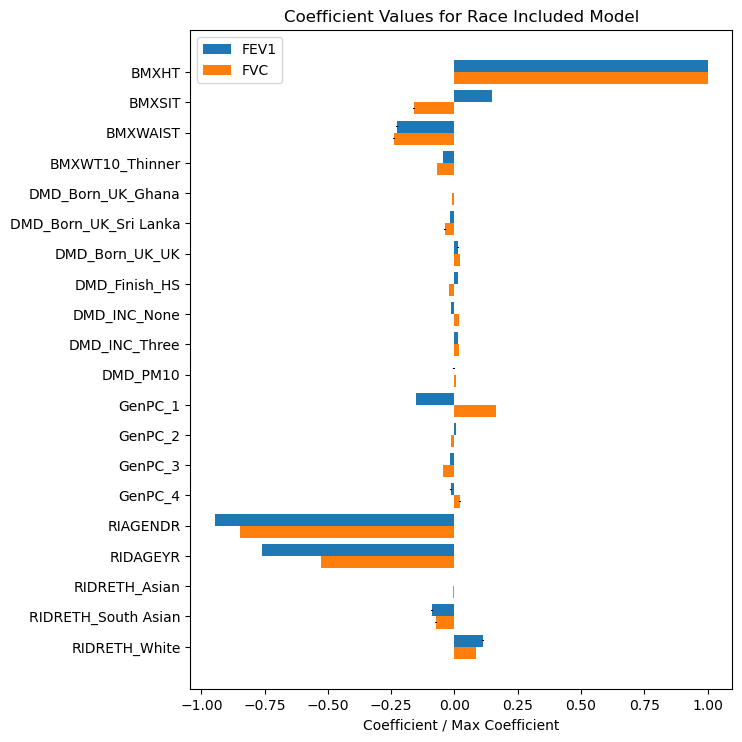

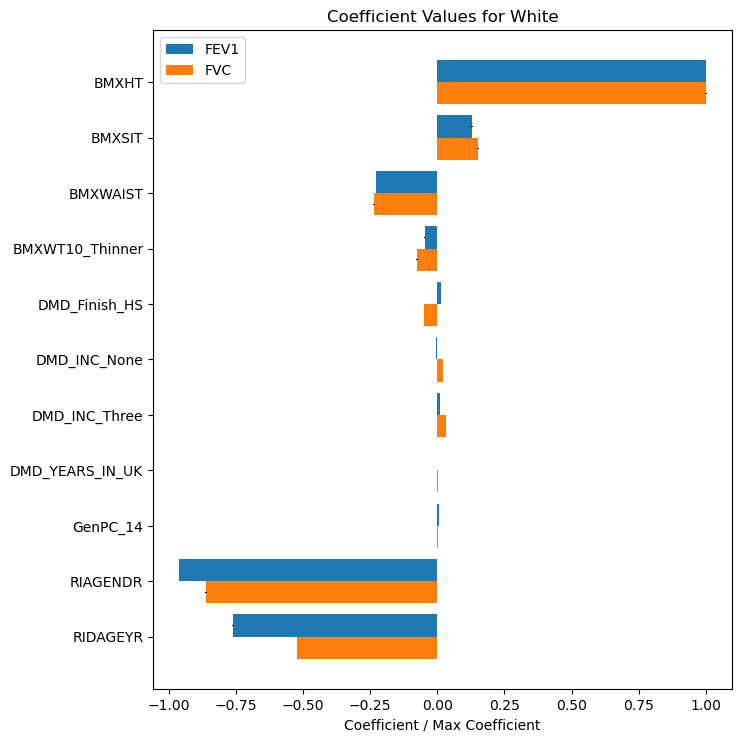

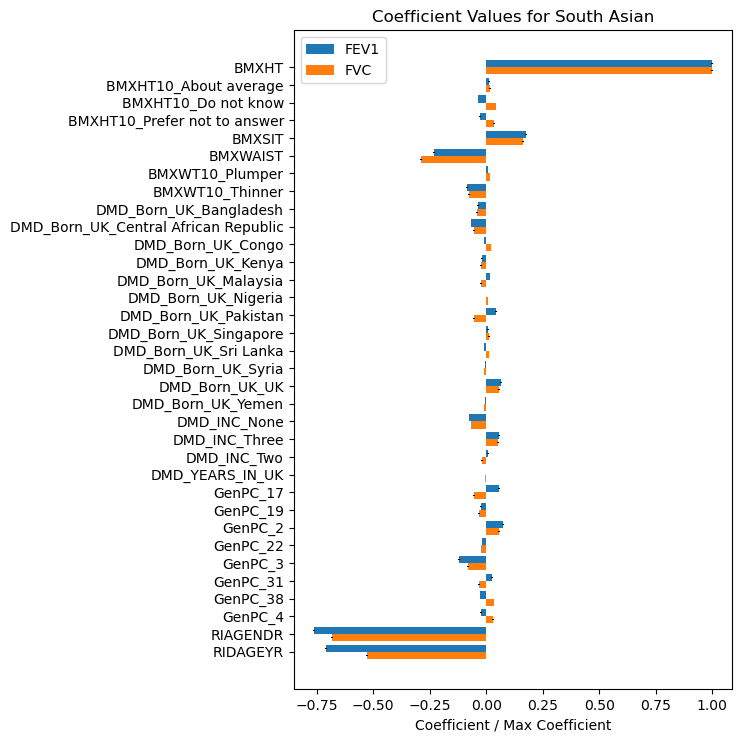

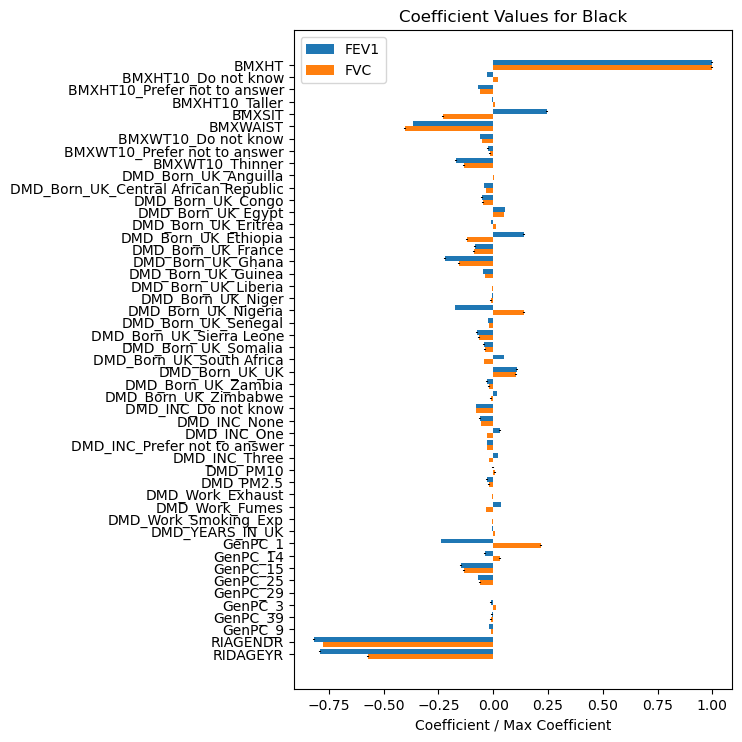

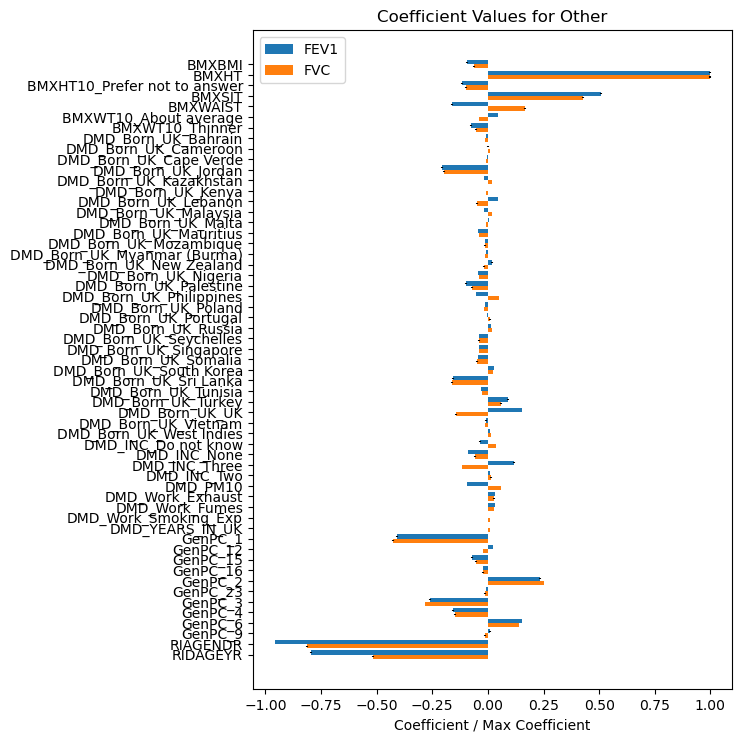

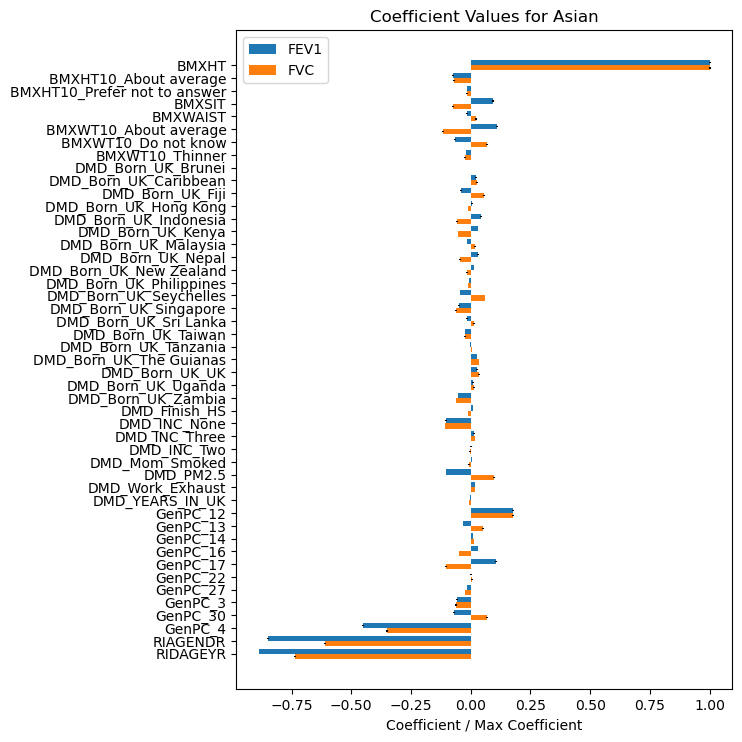

In [14]:
j = 0 
for i, m in enumerate(models.keys()):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)

    coefs_model1 = dict(zip(models[m]["FEV1"]['Features'], models[m]["FEV1"]['Model'].coef_))
    coefs_model2 = dict(zip(models[m]["FVC"]['Features'], models[m]["FVC"]['Model'].coef_))

    names_sorted_1, coef_sorted_1, coef_ci_1 = sorted_feature_imp(models[m]["FEV1"]['Features'], 
                                                                     models[m]["FEV1"]['Model'], 
                                                                     models[m]["FEV1"]['CI Betas'])
    names_sorted_2, coef_sorted_2, coef_ci_2 = sorted_feature_imp(models[m]["FVC"]['Features'], 
                                                                     models[m]["FVC"]['Model'], 
                                                                     models[m]["FVC"]['CI Betas'])

    coefs_model1 = dict(zip(names_sorted_1, coef_sorted_1/max(coef_sorted_1)))
    coefs_model2 = dict(zip(names_sorted_1, coef_sorted_2/max(coef_sorted_2)))

    coefs_betas_model1 = dict(zip(names_sorted_1, coef_ci_1))
    coefs_betas_model2 = dict(zip(names_sorted_2, coef_ci_2))

    labels = set(list(coefs_model1.keys()) + list(coefs_model2.keys()))
    # sort the labels alphabetically
    labels = sorted(list(labels))

    # get the values for each model
    values_model1 = [coefs_model1.get(label, 0) for label in labels]
    values_model2 = [coefs_model2.get(label, 0) for label in labels]

    ci_model1 = [coefs_betas_model1.get(label, 0) for label in labels]
    ci_model2 = [coefs_betas_model2.get(label, 0) for label in labels]

    # define the positions of the bars and the width
    pos = np.arange(len(labels))
    bar_width = 0.4

    # create the figure and axis objects
    
    ax.barh(pos, values_model1, bar_width, label='FEV1', yerr=ci_model1)
    ax.barh(pos + bar_width, values_model2, bar_width, label='FVC', yerr=ci_model2)

    ax.set_yticks(pos + bar_width/2, labels=labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Coefficient / Max Coefficient')
    ax.set_title(f'Coefficient Values for {m}')

    # show the legend
    ax.legend()
    

    fig.tight_layout(pad=10., w_pad=5, h_pad=1.0)
    plt.savefig(f'figures/{m.strip()}', bbox_inches='tight')
    # show the plot
    plt.show()

Target                Model  Alpha  Train MAE  Train CI  Test MAE  \
0       FEV1      Race Free Model   0.01      0.337   0.00014     0.338   
1        FVC      Race Free Model   0.01      0.407   0.00016     0.408   
2   FEV1/FVC      Race Free Model   0.01      0.040   0.00005     0.040   
3       FEV1  Race Included Model   0.01      0.337   0.00015     0.338   
4        FVC  Race Included Model   0.01      0.407   0.00018     0.408   
5   FEV1/FVC  Race Included Model   0.01      0.040   0.00005     0.040   
6       FEV1                White   0.01      0.338   0.00011     0.336   
7        FVC                White   0.01      0.409   0.00011     0.407   
8   FEV1/FVC                White   0.01      0.040   0.00005     0.040   
9       FEV1          South Asian   0.01      0.294   0.00202     0.300   
10       FVC          South Asian   0.01      0.352   0.00236     0.368   
11  FEV1/FVC          South Asian   0.01      0.038   0.00035     0.040   
12      FEV1                Black   0.01      0.318   0.00260     0.310   
13       FVC                Black   0.01      0.373   0.00307     0.352   
14  FEV1/FVC                Black   0.01      0.040   0.00039     0.039   
15      FEV1                Other   0.01      0.330   0.00260     0.331   
16       FVC                Other   0.01      0.391   0.00319     0.386   
17  FEV1/FVC                Other   0.01      0.040   0.00042     0.039   
18      FEV1                Asian   0.01      0.299   0.00407     0.296   
19       FVC                Asian   0.01      0.360   0.00634     0.368   
20  FEV1/FVC                Asian   0.01      0.036   0.00044     0.039   

    Test CI  
0   0.00014  
1   0.00017  
2   0.00005  
3   0.00015  
4   0.00018  
5   0.00005  
6   0.00012  
7   0.00012  
8   0.00006  
9   0.00384  
10  0.00600  
11  0.00043  
12  0.00735  
13  0.00920  
14  0.00027  
15  0.00739  
16  0.00920  
17  0.00022  
18  0.00998  
19  0.01307  
20  0.00038

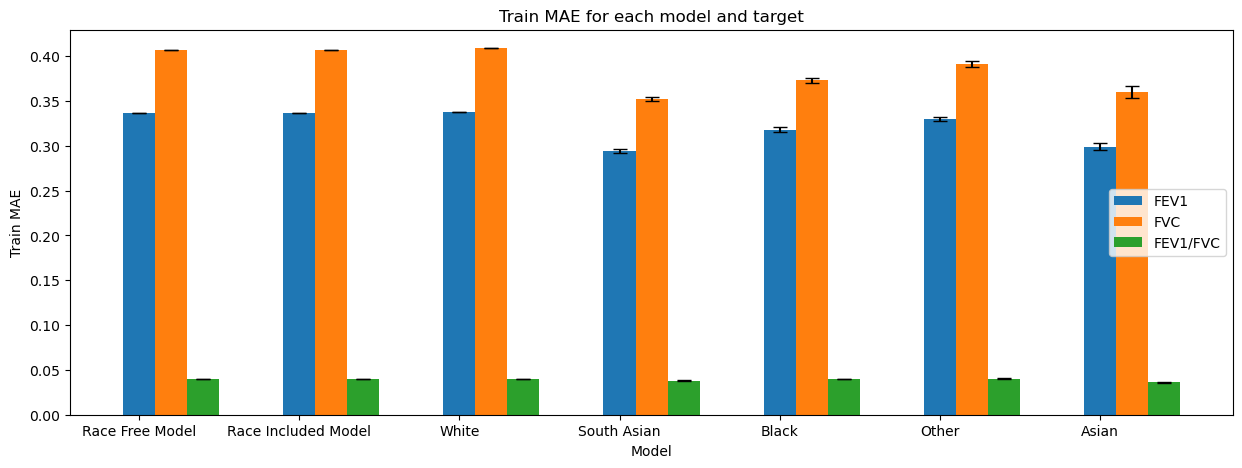

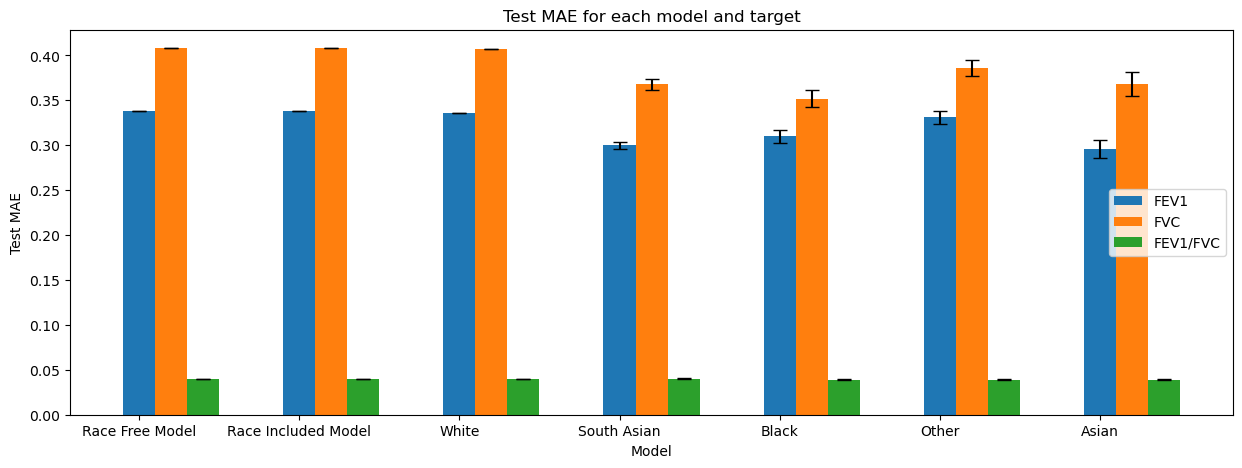

In [17]:
display(model_metrics_df)
maes = ['Train MAE', 'Test MAE']
ci = ['Train CI', 'Test CI']

for j in range(2):
    # set colors for each target
    colors = {'FEV1': 'tab:blue', 'FVC': 'tab:orange', 'FEV1/FVC': 'tab:green'}

    # create figure and axis objects
    fig, ax = plt.subplots(figsize=(15,5))

    # create x-axis
    x_labels = np.arange(len(model_metrics_df['Model'].unique()))

    # loop through each target and plot bar for each model
    for i, target in enumerate(model_metrics_df['Target'].unique()):
        subset = model_metrics_df[model_metrics_df['Target'] == target]
        x = [x_labels + 0.2 * i for x_labels in x_labels]
        ax.bar(x, subset[maes[j]], width=0.2, label=target, color=colors[target], yerr=subset[ci[j]], capsize=5)

    # add labels and title
    ax.set_xlabel('Model')
    ax.set_ylabel(maes[j])
    ax.set_title(f'{maes[j]} for each model and target')
    ax.set_xticks(x_labels)
    ax.set_xticklabels(model_metrics_df['Model'].unique())
    ax.legend()

    plt.show()

Model    Target         Race       MAE
0       Race Free Model      FEV1        White  0.337935
1       Race Free Model       FVC        White  0.408723
2       Race Free Model  FEV1/FVC        White  0.039537
3   Race Included Model      FEV1        White  0.337881
4   Race Included Model       FVC        White  0.408661
5   Race Included Model  FEV1/FVC        White  0.039537
6       Race Free Model      FEV1        Black  0.333812
7       Race Free Model       FVC        Black  0.396388
8       Race Free Model  FEV1/FVC        Black  0.045129
9   Race Included Model      FEV1        Black  0.333923
10  Race Included Model       FVC        Black  0.395790
11  Race Included Model  FEV1/FVC        Black  0.045129
12      Race Free Model      FEV1        Asian  0.298862
13      Race Free Model       FVC        Asian  0.387516
14      Race Free Model  FEV1/FVC        Asian  0.041056
15  Race Included Model      FEV1        Asian  0.314534
16  Race Included Model       FVC        Asian  0.397172
17  Race Included Model  FEV1/FVC        Asian  0.041056
18      Race Free Model      FEV1  South Asian  0.328324
19      Race Free Model       FVC  South Asian  0.389247
20      Race Free Model  FEV1/FVC  South Asian  0.041474
21  Race Included Model      FEV1  South Asian  0.314880
22  Race Included Model       FVC  South Asian  0.373891
23  Race Included Model  FEV1/FVC  South Asian  0.041474
24      Race Free Model      FEV1        Other  0.357622
25      Race Free Model       FVC        Other  0.423713
26      Race Free Model  FEV1/FVC        Other  0.044140
27  Race Included Model      FEV1        Other  0.368012
28  Race Included Model       FVC        Other  0.431972
29  Race Included Model  FEV1/FVC        Other  0.044140

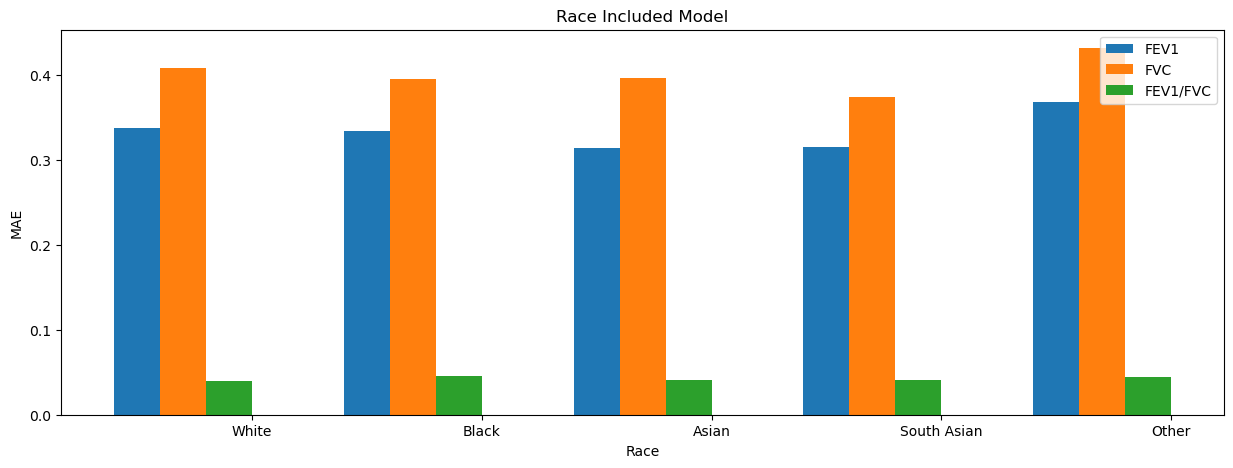

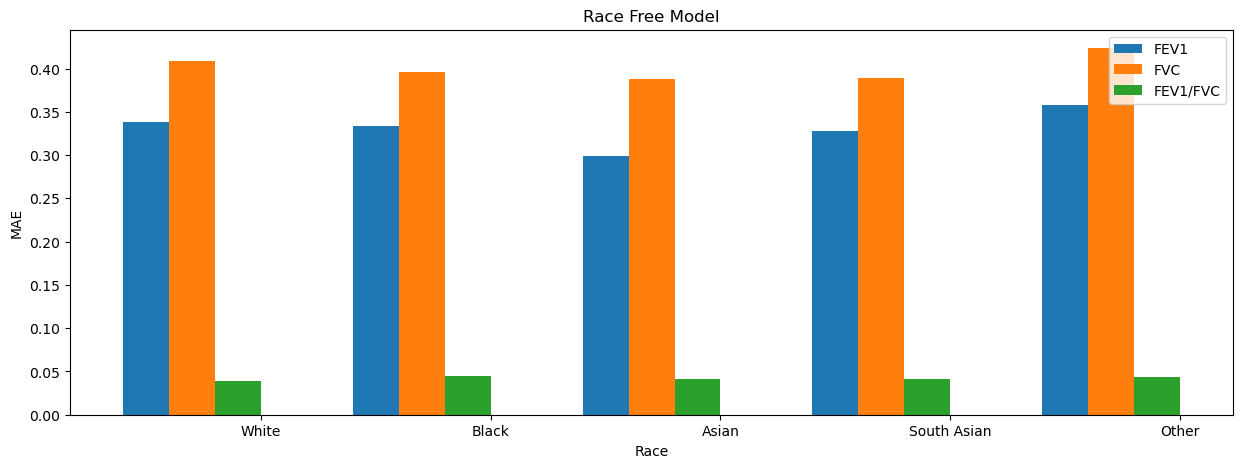

In [16]:
race_free_metrics = pd.DataFrame(columns = ['Model', 'Target', 'White', 'Black', 'Asian', 'South Asian', 'Other'])
race_metrics = []
for m in ['Race Free Model', 'Race Included Model']:
    for i in ['FEV1', 'FVC', 'FEV1/FVC']:
        race_metrics_dict = {}
        race_metrics_dict['Model'] = m
        race_metrics_dict['Target'] = i
        race_metrics_dict.update(models[m][i]['Race MAE'])
        race_metrics.append(race_metrics_dict)
        
race_metrics_df = pd.DataFrame(race_metrics)   
race_metrics_df = pd.melt(race_metrics_df, id_vars=['Model', 'Target'], value_vars=['White', 'Black', 
                                                            'Asian', 'South Asian',
                                                            'Other'], var_name='Race', value_name='MAE')
display(race_metrics_df)

# set colors for each target
colors = {'FEV1': 'tab:blue', 'FVC': 'tab:orange', 'FEV1/FVC': 'tab:green'}

# create figure and axis objects
fig, ax = plt.subplots(figsize=(15,5))

# Create a new dataframe for the race included model
df_included = race_metrics_df[race_metrics_df['Model'] == 'Race Included Model']

# Define the width of each bar
width = 0.2

# Create a barplot for the race included model
for i, target in enumerate(['FEV1', 'FVC', 'FEV1/FVC']):
    df_target = df_included[df_included['Target'] == target]
    x = [j + i * width for j in range(len(df_target['Race']))]
    ax.bar(x, df_target['MAE'], width=width, color=colors[target], label=target)

ax.set_xticks([j + 0.5 for j in range(len(df_target['Race']))])
ax.set_xticklabels(df_target['Race'])
ax.set_xlabel('Race')
ax.set_ylabel('MAE')
ax.set_title('Race Included Model')
ax.legend()
plt.show()

# create figure and axis objects
fig, ax = plt.subplots(figsize=(15,5))

# Create a new dataframe for the race free model
df_free = race_metrics_df[race_metrics_df['Model'] == 'Race Free Model']

# Create a barplot for the race free model
for i, target in enumerate(['FEV1', 'FVC', 'FEV1/FVC']):
    df_target = df_free[df_free['Target'] == target]
    x = [j + i * width for j in range(len(df_target['Race']))]
    ax.bar(x, df_target['MAE'], width=width, color=colors[target], label=target)

ax.set_xticks([j + 0.5 for j in range(len(df_target['Race']))])
ax.set_xticklabels(df_target['Race'])
ax.set_xlabel('Race')
ax.set_ylabel('MAE')
ax.set_title('Race Free Model')
ax.legend()
plt.show()

# for i, mod in enumerate(['Race Free Model', 'Race Included Model']):
#     df_target = df_included[df_included['Model'] == mod]
#     x = [j + i * width for j in range(len(df_target['Model']))]
#     print(x)
#     ax.bar(x, df_target['MAE'], width=width, color=colors[target], label=target)
#     ax.set_xticks([j + 0.5 for j in range(len(df_target['Model']))])
#     ax.set_xticklabels(df_target['Model'])
#     ax.set_xlabel('Race')
#     ax.set_ylabel('MAE')
#     ax.set_title('Race Included Model')
#     ax.legend()
#     plt.show()

### Clinical Outcomes

1) How well do the models perform on NOT healthy people?

Lung Cancer Race Free Model FEV1
Lung Cancer Race Free Model FVC
Lung Cancer Race Free Model FEV1/FVC


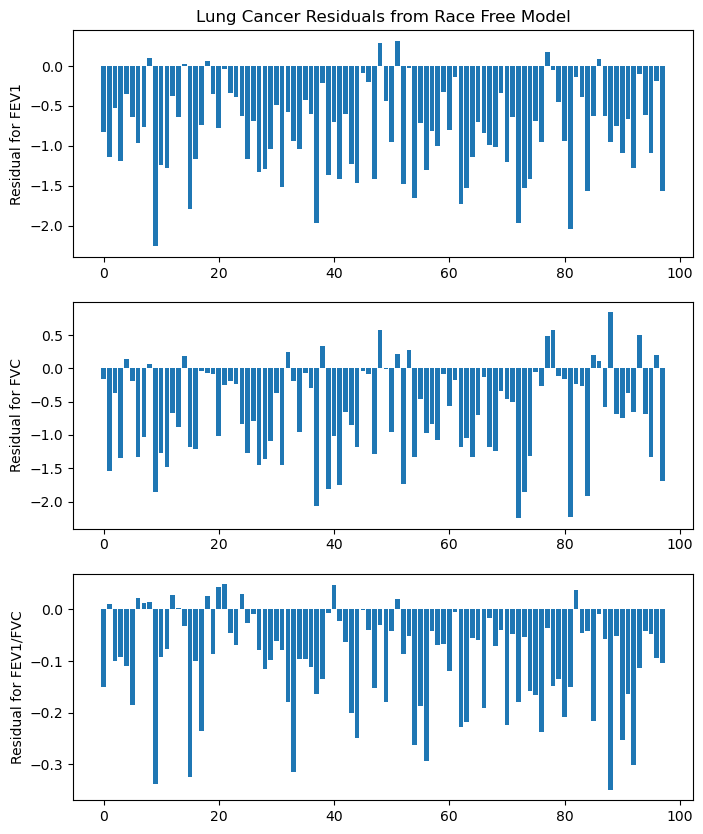

Lung Cancer Race Included Model FEV1
Lung Cancer Race Included Model FVC
Lung Cancer Race Included Model FEV1/FVC


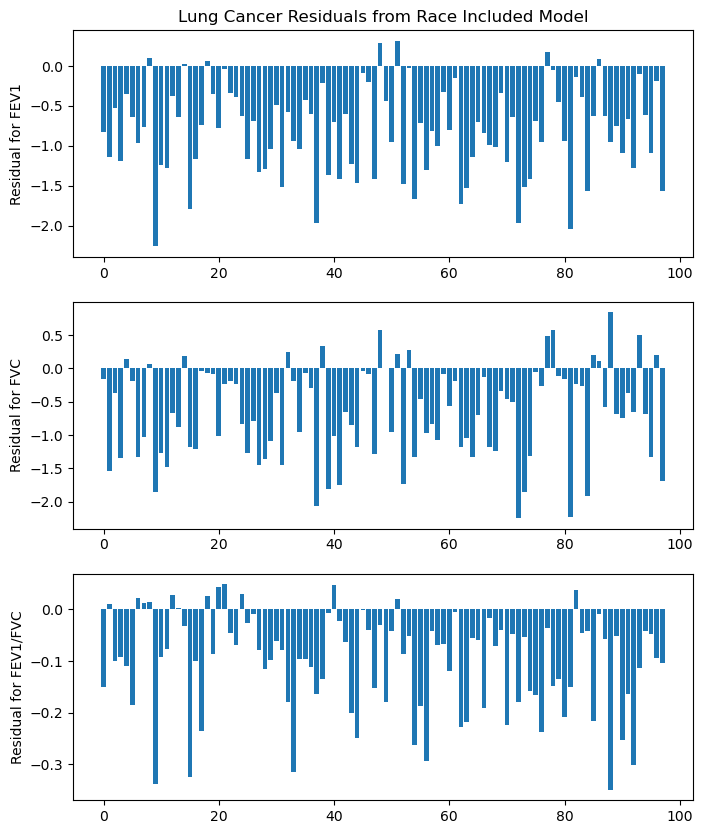

Respiratory Disease Race Free Model FEV1
Respiratory Disease Race Free Model FVC
Respiratory Disease Race Free Model FEV1/FVC


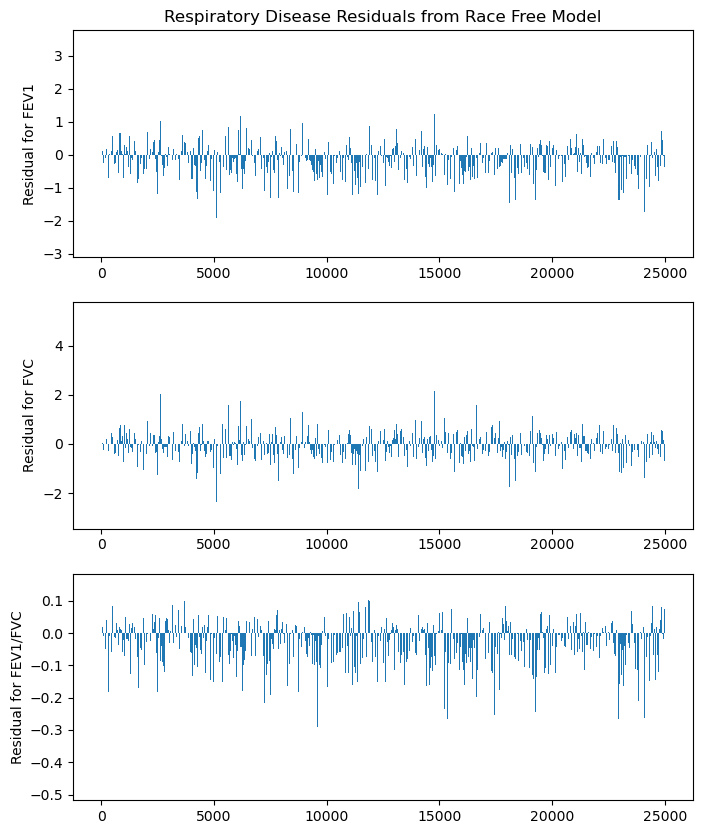

Respiratory Disease Race Included Model FEV1
Respiratory Disease Race Included Model FVC
Respiratory Disease Race Included Model FEV1/FVC


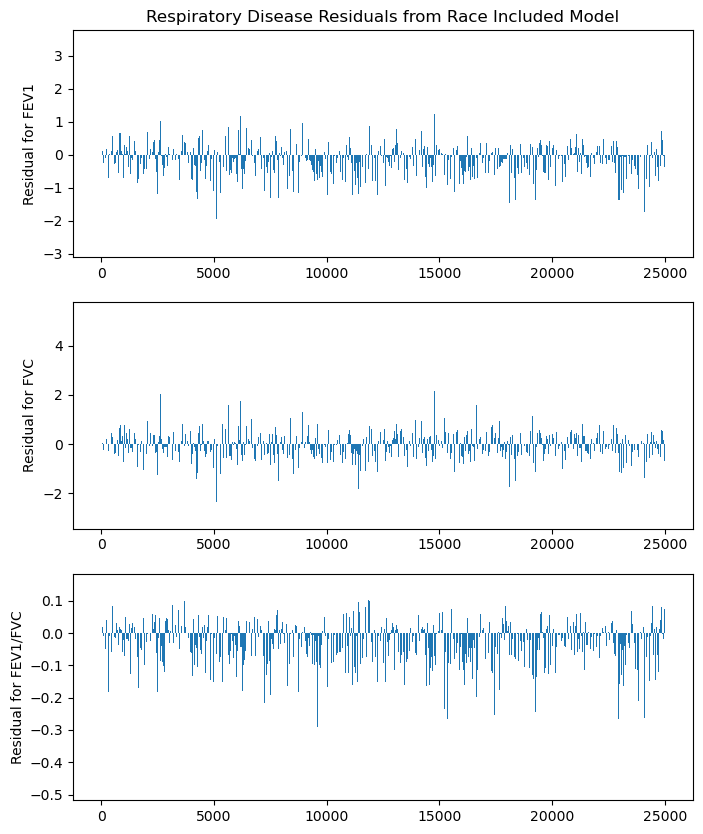

Smokers Race Free Model FEV1
Smokers Race Free Model FVC
Smokers Race Free Model FEV1/FVC


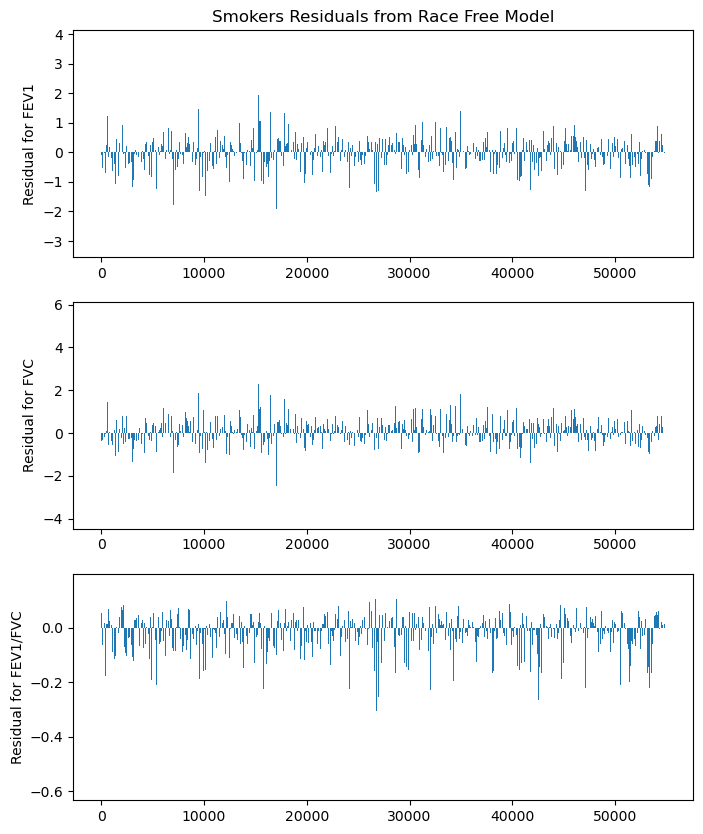

Smokers Race Included Model FEV1
Smokers Race Included Model FVC
Smokers Race Included Model FEV1/FVC


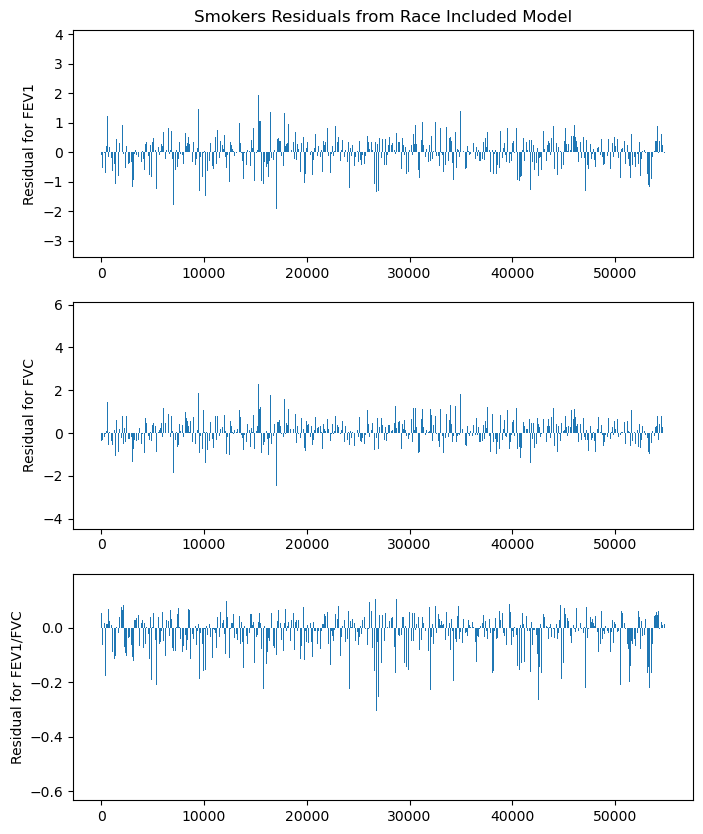

Respiratory Symptoms Race Free Model FEV1
Respiratory Symptoms Race Free Model FVC
Respiratory Symptoms Race Free Model FEV1/FVC


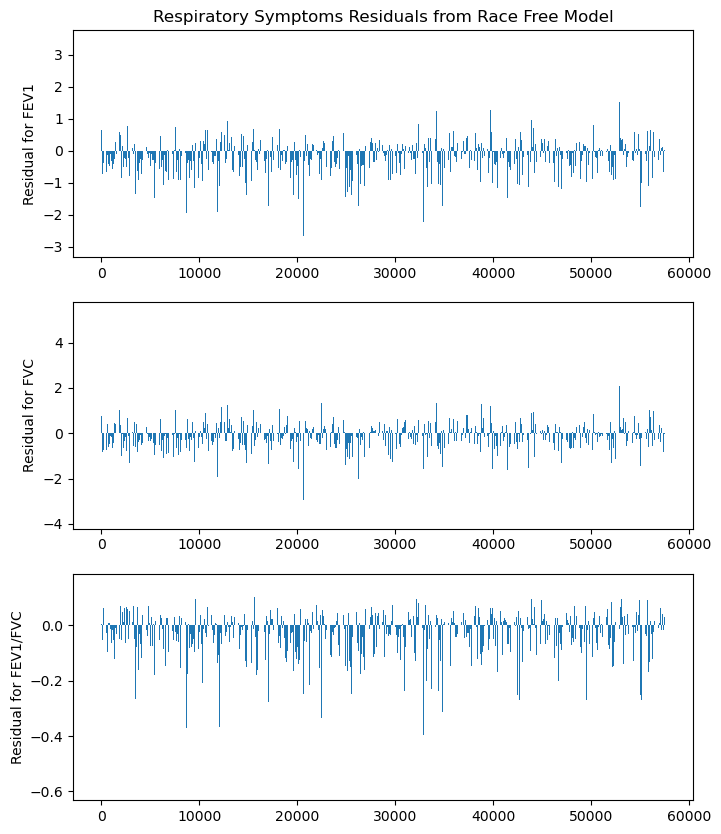

Respiratory Symptoms Race Included Model FEV1
Respiratory Symptoms Race Included Model FVC
Respiratory Symptoms Race Included Model FEV1/FVC


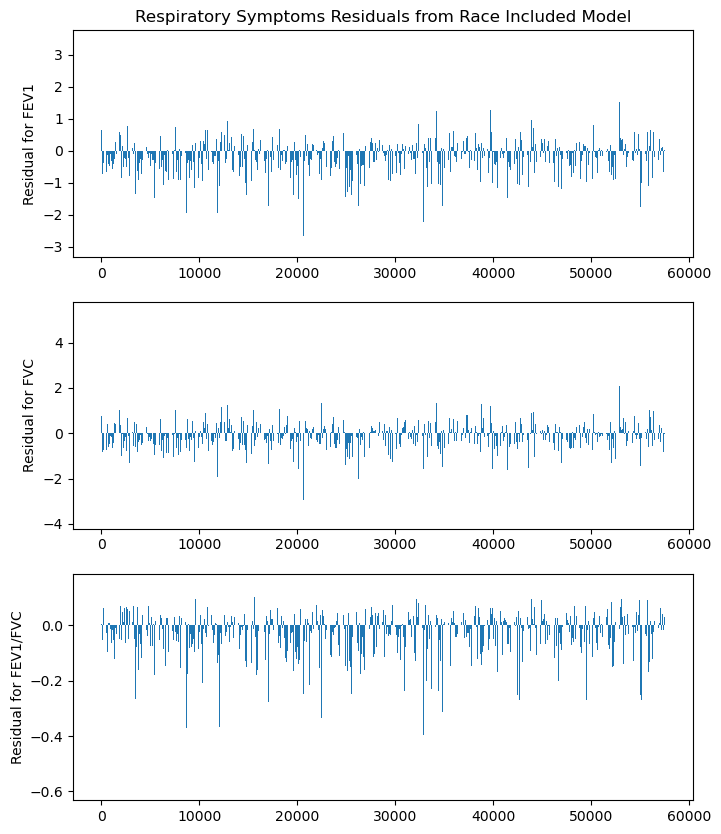

In [18]:
smokers = ukb_clean[ukb_clean[["EXCL_SMOKED_100", "EXCL_SMOKER"]].any(axis=1)]
respiratory_cancer = ukb_clean.query("MCQ_LUNG_CANCER")
respiratory_disease = ukb_clean.query("MCQ_RESPIRATORY_DISEASE")
respiratory_symptoms = ukb_clean[ukb_clean[["SYMP_COUGH","SYMP_PHLEGM","SYMP_WHEEZING"]].any(axis=1)]
list_dfs = [respiratory_cancer, respiratory_disease, smokers, respiratory_symptoms]
list_str = ['Lung Cancer', 'Respiratory Disease', 'Smokers', 'Respiratory Symptoms']

rows = []

for i, df in enumerate(list_dfs):
    for j, m in enumerate(["Race Free Model", "Race Included Model"]):
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))
        for k, p in enumerate(PFT):
            model = models[m][p]['Model']
            features = models[m][p]['Features']
            key = 'Race Free Model'
            cols = list(filter(lambda x: x.startswith(('RIDAGEYR', "RIAGENDR", 'BMX', 'DMD'
                                                      )), ukb_healthy.columns))
            
            X, y = one_hot_encoding(df, cols, p)

            # Check if col2 and col3 are in the DataFrame
            missing_cols = set(features) - set(X.columns)
        
            # Add missing columns to the DataFrame and fill with zeros
            if missing_cols:
                for col in missing_cols:
                    X[col] = False

            # Select the columns from the DataFrame
            y_pred = model.predict(X[features])
            
            print(list_str[i], m, p)
            if k == 0:
                axes[k].set_title(list_str[i] + ' Residuals from ' + m)
            axes[k].bar(range(len(y)), y-y_pred)
            axes[k].set_ylabel('Residual for ' + p)
            
            row = [list_str[i],
                   m,
                   p,
                   mean_absolute_error(y_pred, y)]
            rows.append(row)
        plt.show()

unhealthy_metrics_df = pd.DataFrame(rows, columns = ["Disease", "Model", "Target", "MAE"])

In [20]:
unhealthy_metrics_df

Disease                Model    Target       MAE
0            Lung Cancer      Race Free Model      FEV1  0.844125
1            Lung Cancer      Race Free Model       FVC  0.775651
2            Lung Cancer      Race Free Model  FEV1/FVC  0.108516
3            Lung Cancer  Race Included Model      FEV1  0.844124
4            Lung Cancer  Race Included Model       FVC  0.775730
5            Lung Cancer  Race Included Model  FEV1/FVC  0.108516
6    Respiratory Disease      Race Free Model      FEV1  0.435161
7    Respiratory Disease      Race Free Model       FVC  0.451244
8    Respiratory Disease      Race Free Model  FEV1/FVC  0.064692
9    Respiratory Disease  Race Included Model      FEV1  0.435102
10   Respiratory Disease  Race Included Model       FVC  0.451155
11   Respiratory Disease  Race Included Model  FEV1/FVC  0.064692
12               Smokers      Race Free Model      FEV1  0.395709
13               Smokers      Race Free Model       FVC  0.450192
14               Smokers      Race Free Model  FEV1/FVC  0.050607
15               Smokers  Race Included Model      FEV1  0.395682
16               Smokers  Race Included Model       FVC  0.450142
17               Smokers  Race Included Model  FEV1/FVC  0.050607
18  Respiratory Symptoms      Race Free Model      FEV1  0.443467
19  Respiratory Symptoms      Race Free Model       FVC  0.469714
20  Respiratory Symptoms      Race Free Model  FEV1/FVC  0.059777
21  Respiratory Symptoms  Race Included Model      FEV1  0.443408
22  Respiratory Symptoms  Race Included Model       FVC  0.469633
23  Respiratory Symptoms  Race Included Model  FEV1/FVC  0.059777

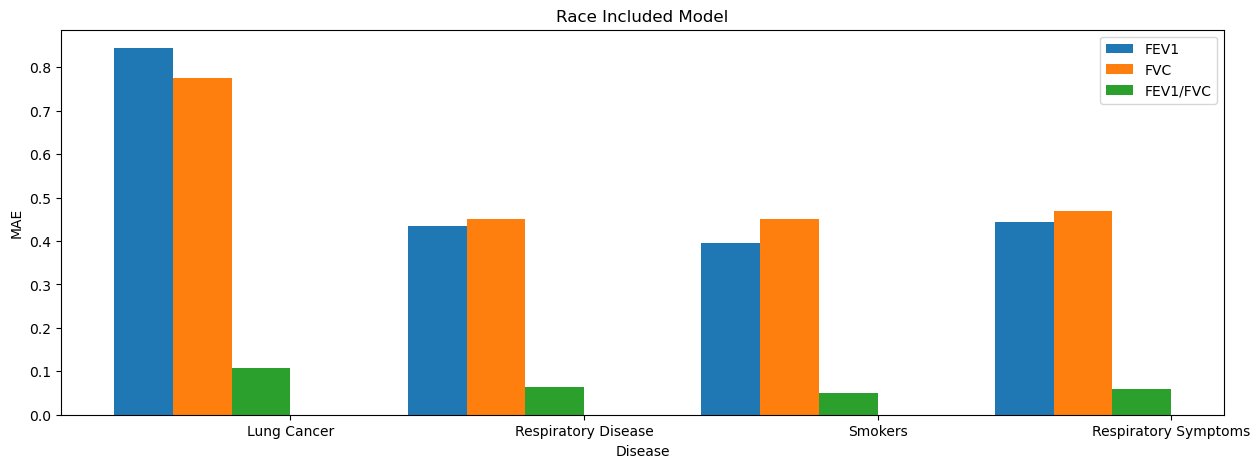

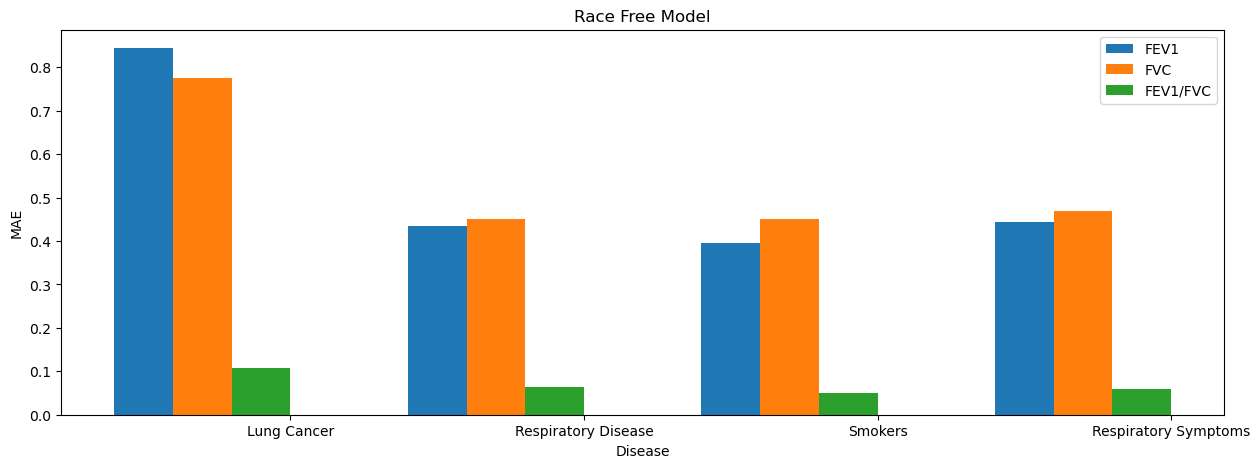

In [19]:
# set colors for each target
colors = {'FEV1': 'tab:blue', 'FVC': 'tab:orange', 'FEV1/FVC': 'tab:green'}

# create figure and axis objects
fig, ax = plt.subplots(figsize=(15,5))

# Create a new dataframe for the race included model
df_included = unhealthy_metrics_df[unhealthy_metrics_df['Model'] == 'Race Included Model']

# Define the width of each bar
width = 0.2

# Create a barplot for the race included model
for i, target in enumerate(['FEV1', 'FVC', 'FEV1/FVC']):
    df_target = df_included[df_included['Target'] == target]
    x = [j + i * width for j in range(len(df_target['Disease']))]
    ax.bar(x, df_target['MAE'], width=width, color=colors[target], label=target)

ax.set_xticks([j + 0.5 for j in range(len(df_target['Disease']))])
ax.set_xticklabels(df_target['Disease'])
ax.set_xlabel('Disease')
ax.set_ylabel('MAE')
ax.set_title('Race Included Model')
ax.legend()
plt.show()

# create figure and axis objects
fig, ax = plt.subplots(figsize=(15,5))

# Create a new dataframe for the race free model
df_free = unhealthy_metrics_df[unhealthy_metrics_df['Model'] == 'Race Free Model']

# Create a barplot for the race free model
for i, target in enumerate(['FEV1', 'FVC', 'FEV1/FVC']):
    df_target = df_free[df_free['Target'] == target]
    x = [j + i * width for j in range(len(df_target['Disease']))]
    ax.bar(x, df_target['MAE'], width=width, color=colors[target], label=target)

ax.set_xticks([j + 0.5 for j in range(len(df_target['Disease']))])
ax.set_xticklabels(df_target['Disease'])
ax.set_xlabel('Disease')
ax.set_ylabel('MAE')
ax.set_title('Race Free Model')
ax.legend()
plt.show()



In [ ]:
2) How would this affect their diagnosis? 